<a href="https://colab.research.google.com/github/ElMartinez31/Data_Science/blob/main/Projects/Temporal_Series/Store_Sales_Forecast/notebooks/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/walidkw/store-sales-ts-forecasting-xgboost


Let's work on the Store Sales TS forecasting Kaggle competition.


The idea will be to reproduce in our way what already exist. Complete/change/criticize what has been done.

Store Sales - Time Series Forecasting¶
Before reading the notebook, what will you learn from this notebook?

Interpolation for Oil Prices
Detailed Data Manipulation for Holiday and Events Data
Exploratory Data Analysis
Hypothesis Testing
Modelling
This competition is about time series forcasting for store sales. The data comes from an Ecuador company as known as Corporación Favorita and it is a large grocery retailer. Also, the company operates in other countries in South America.

There are 54 stores and 33 prodcut families in the data. The time serie starts from 2013-01-01 and finishes in 2017-08-31. However, you know that Kaggle gives us splitted two data as train and test. The dates in the test data are for the 15 days after the last date in the training data. Date range in the test data will be very important to us while we are defining a cross-validation strategy and creating new features.

Our main mission in this competition is, predicting sales for each product family and store combinations.



There are 6 data that we will study on them step by step.

Train
Test
Store
Transactions
Holidays and Events
Daily Oil Price
The train data contains time series of the stores and the product families combination. The sales column gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).The onpromotion column gives the total number of items in a product family that were being promoted at a store at a given date.

Stores data gives some information about stores such as city, state, type, cluster.

Transaction data is highly correlated with train's sales column. You can understand the sales patterns of the stores.

Holidays and events data is a meta data. This data is quite valuable to understand past sales, trend and seasonality components. However, it needs to be arranged. You are going to find a comprehensive data manipulation for this data. That part will be one of the most important chapter in this notebook.

Daily Oil Price data is another data which will help us. Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices. That's why, it will help us to understand which product families affected in positive or negative way by oil price.

When you look at the data description, you will see "Additional Notes". These notes may be significant to catch some patterns or anomalies. I'm sharing them with you to remember.
Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

# 1/ Imports

In [126]:
import sys
print(sys.executable)

/usr/bin/python3


In [127]:

# BASE
# ------------------------------------------------------
import numpy as np
import pandas as pd
import os
import gc
import warnings

# PACF - ACF
# ------------------------------------------------------
import statsmodels.api as sm

# DATA VISUALIZATION
# ------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [128]:
pd.set_option('display.max_columns', None)

print(os.getcwd())


/content


In [129]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [130]:
# # 2/ Read Data


# from codespace
# hl_events_df = pd.read_csv("../data/raw/holidays_events.csv")
# #hl_events.head()
# oil_df = pd.read_csv("../data/raw/oil.csv")
# train_df = pd.read_csv("../data/raw/train.csv")
# test_df = pd.read_csv("../data/raw/test.csv")
# stores_df = pd.read_csv("../data/raw/stores.csv")
# transactions_df = pd.read_csv("../data/raw/transactions.csv")

# auto adaptive
import sys
import pandas as pd

# Détection de l'environnement
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    data_path = "/content/drive/Othercomputers/Mon ordinateur portable/Data Science/Datasets/Store Sales TS Project/"
else:
    data_path = "../data/raw/"

# Chargement des fichiers
hl_events_df = pd.read_csv(data_path + "holidays_events.csv")
oil_df = pd.read_csv(data_path + "oil.csv")
train_df = pd.read_csv(data_path + "train.csv")
test_df = pd.read_csv(data_path + "test.csv")
stores_df = pd.read_csv(data_path + "stores.csv")
transactions_df = pd.read_csv(data_path + "transactions.csv")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [131]:
transactions_df

date  store_nbr  transactions
0      2013-01-01         25           770
1      2013-01-02          1          2111
2      2013-01-02          2          2358
3      2013-01-02          3          3487
4      2013-01-02          4          1922
...           ...        ...           ...
83483  2017-08-15         50          2804
83484  2017-08-15         51          1573
83485  2017-08-15         52          2255
83486  2017-08-15         53           932
83487  2017-08-15         54           802

[83488 rows x 3 columns]

In [132]:
# 3/ Adapt types
hl_events_df["date"] = pd.to_datetime(hl_events_df["date"])
train_df["date"] = pd.to_datetime(train_df["date"])
test_df["date"] = pd.to_datetime(test_df["date"])
oil_df["date"] = pd.to_datetime(oil_df["date"])
transactions_df["date"] = pd.to_datetime(transactions_df["date"])
hl_events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [133]:
hl_events_df.head()
# 350 rows
# each row for a day of holiday, associated to a region (national or local)
hl_events_df.tail()

date        type    locale locale_name description  transferred
345 2017-12-22  Additional  National     Ecuador   Navidad-3        False
346 2017-12-23  Additional  National     Ecuador   Navidad-2        False
347 2017-12-24  Additional  National     Ecuador   Navidad-1        False
348 2017-12-25     Holiday  National     Ecuador     Navidad        False
349 2017-12-26  Additional  National     Ecuador   Navidad+1        False

In [134]:
stores_df.head()
# 54 rows
# 1 row/store + city associated + type
stores_df.tail()

store_nbr       city       state type  cluster
49         50     Ambato  Tungurahua    A       14
50         51  Guayaquil      Guayas    A       17
51         52      Manta      Manabi    A       11
52         53      Manta      Manabi    D       13
53         54  El Carmen      Manabi    C        3

In [135]:
train_df.head(10000)
#train_df.info()
# 3 M rows
# 1 row/store/family product ?
#from 2013-01-01 to 2017-08-15

id       date  store_nbr                      family  sales  \
0        0 2013-01-01          1                  AUTOMOTIVE   0.00   
1        1 2013-01-01          1                   BABY CARE   0.00   
2        2 2013-01-01          1                      BEAUTY   0.00   
3        3 2013-01-01          1                   BEVERAGES   0.00   
4        4 2013-01-01          1                       BOOKS   0.00   
...    ...        ...        ...                         ...    ...   
9995  9995 2013-01-06         39              PREPARED FOODS  47.00   
9996  9996 2013-01-06         39                     PRODUCE   0.00   
9997  9997 2013-01-06         39  SCHOOL AND OFFICE SUPPLIES   0.00   
9998  9998 2013-01-06         39                     SEAFOOD  19.54   
9999  9999 2013-01-06          4                  AUTOMOTIVE   4.00   

      onpromotion  
0               0  
1               0  
2               0  
3               0  
4               0  
...           ...  
9995            0  
9996            0  
9997            0  
9998            0  
9999            0  

[10000 rows x 6 columns]

In [136]:
test_df.head()

id       date  store_nbr      family  onpromotion
0  3000888 2017-08-16          1  AUTOMOTIVE            0
1  3000889 2017-08-16          1   BABY CARE            0
2  3000890 2017-08-16          1      BEAUTY            2
3  3000891 2017-08-16          1   BEVERAGES           20
4  3000892 2017-08-16          1       BOOKS            0

In [137]:
oil_df.head()
# 1218 rows of oil price, 1row/day
#oil_df.info()

date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02       93.14
2 2013-01-03       92.97
3 2013-01-04       93.12
4 2013-01-07       93.20

In [138]:
transactions_df.head(10)
# 1 row/store/day
# 83k rows
#transactions_df.info()

date  store_nbr  transactions
0 2013-01-01         25           770
1 2013-01-02          1          2111
2 2013-01-02          2          2358
3 2013-01-02          3          3487
4 2013-01-02          4          1922
5 2013-01-02          5          1903
6 2013-01-02          6          2143
7 2013-01-02          7          1874
8 2013-01-02          8          3250
9 2013-01-02          9          2940

# Questions
- How to merge these datasets?
- How to work on the data to get the good granularity?
- What vizu to build to get more insights?
- Transactions gives global transaction per store per day when train gives one degree of granularity furthers, providing also the product family => How to link both?

In [139]:
train_df.head()

sales_df = pd.DataFrame(train_df.groupby(["date", "store_nbr"]).sales.sum()).reset_index()
# rappelons que groupby() et sum() vont transformer les colonnes de group en index (donc multi index ici)
# ilfaut donc utiliser le reset_index pour s'en prémunir.
type(sales_df)#df
sales_df.head()

sales_df.info() # 91k rows
# transactions_df.head()
transactions_df.info() # 83K rows

sales_vs_transact_df = pd.merge(sales_df, transactions_df, how="left", on = ["date", "store_nbr"])
sales_vs_transact_df.head()





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90936 entries, 0 to 90935
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       90936 non-null  datetime64[ns]
 1   store_nbr  90936 non-null  int64         
 2   sales      90936 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


date  store_nbr  sales  transactions
0 2013-01-01          1    0.0           NaN
1 2013-01-01          2    0.0           NaN
2 2013-01-01          3    0.0           NaN
3 2013-01-01          4    0.0           NaN
4 2013-01-01          5    0.0           NaN

In [140]:
# let's compute the correlation between transactions and sales

sales_vs_transact_df["transactions"].corr(sales_vs_transact_df["sales"], method="pearson")
# 0.837 very high correlation
sales_vs_transact_df["transactions"].corr(sales_vs_transact_df["sales"], method="spearman")
# 0.817

np.float64(0.8174644354591598)

# Sales - Transactions

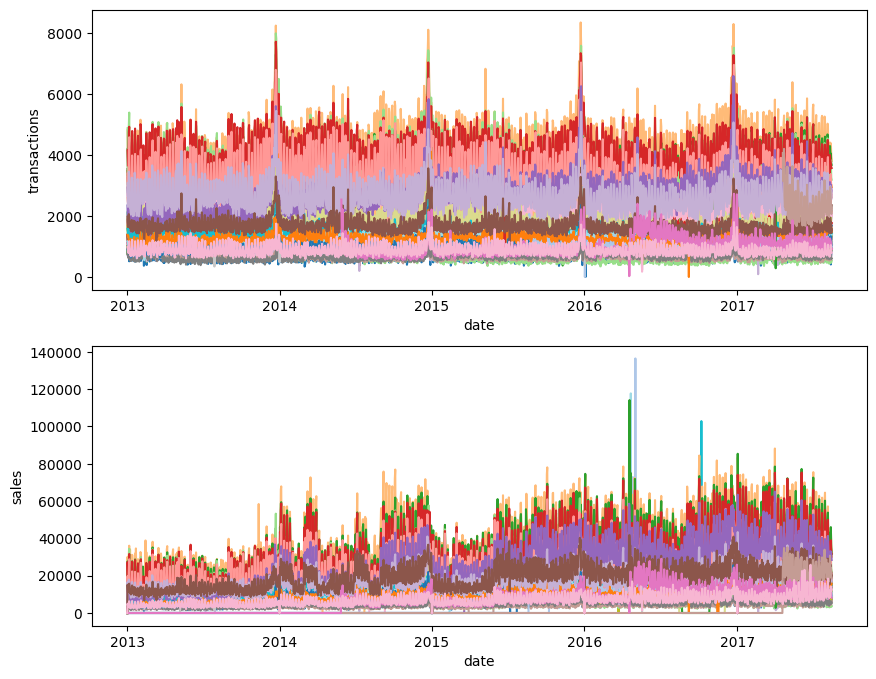

In [141]:
# OK now let's plot
# let's color by store

# Make one plot
# plt.figure(figsize = (10,8))
# # sns.scatterplot(sales_vs_transact_df.sort_values(["store_nbr", "date"]), x = "date", y="transactions", hue = "store_nbr", palette = "tab20" )
# sns.lineplot(sales_vs_transact_df.sort_values(["store_nbr", "date"]), x = "date", y="transactions", hue = "store_nbr", palette = "tab20" )
# plt.legend([], [], frameon=False)  #supprime la légende
# # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# plt.tight_layout()
# plt.show()
# #bbox_to_anchor=(1.05, 1) place la légende à droite, juste à l'extérieur du plot.


# lineplot plus visible et préférables pour ce genre ed données temporelles régulieres


fig, axes = plt.subplots(nrows = 2, ncols = 1 , figsize = (10,8))

sns.lineplot(sales_vs_transact_df.sort_values(["store_nbr", "date"]),
            x = "date",
            y="transactions",
            hue = "store_nbr",
            palette = "tab20",
            ax=axes[0] )
axes[0].legend([], [], frameon=False)
# we can see a recurrence in the data, with a peak each year in december ("navidad" rush)

sns.lineplot(sales_vs_transact_df.sort_values(["store_nbr", "date"]),
            x = "date",
            y="sales",
            hue = "store_nbr",
            palette = "tab20",
            ax=axes[1] )
axes[1].legend([], [], frameon=False)
plt.show()

# even tho there is a high correlation between sales and transactions, we don't see the same pattern as for transactions here with sales.
# we see a peak in apreil 2016 (aligned with the earthquake)




In [142]:
# let's plot boxplots by month to confirm that

# to do that we need to extract year-month

sales_vs_transact_df["year_month"] = sales_vs_transact_df["date"].dt.strftime(  date_format= "%Y-%m")
sales_vs_transact_df["year"] = sales_vs_transact_df["date"].dt.year
sales_vs_transact_df["month"] = sales_vs_transact_df["date"].dt.month
sales_vs_transact_df.head()

date  store_nbr  sales  transactions year_month  year  month
0 2013-01-01          1    0.0           NaN    2013-01  2013      1
1 2013-01-01          2    0.0           NaN    2013-01  2013      1
2 2013-01-01          3    0.0           NaN    2013-01  2013      1
3 2013-01-01          4    0.0           NaN    2013-01  2013      1
4 2013-01-01          5    0.0           NaN    2013-01  2013      1

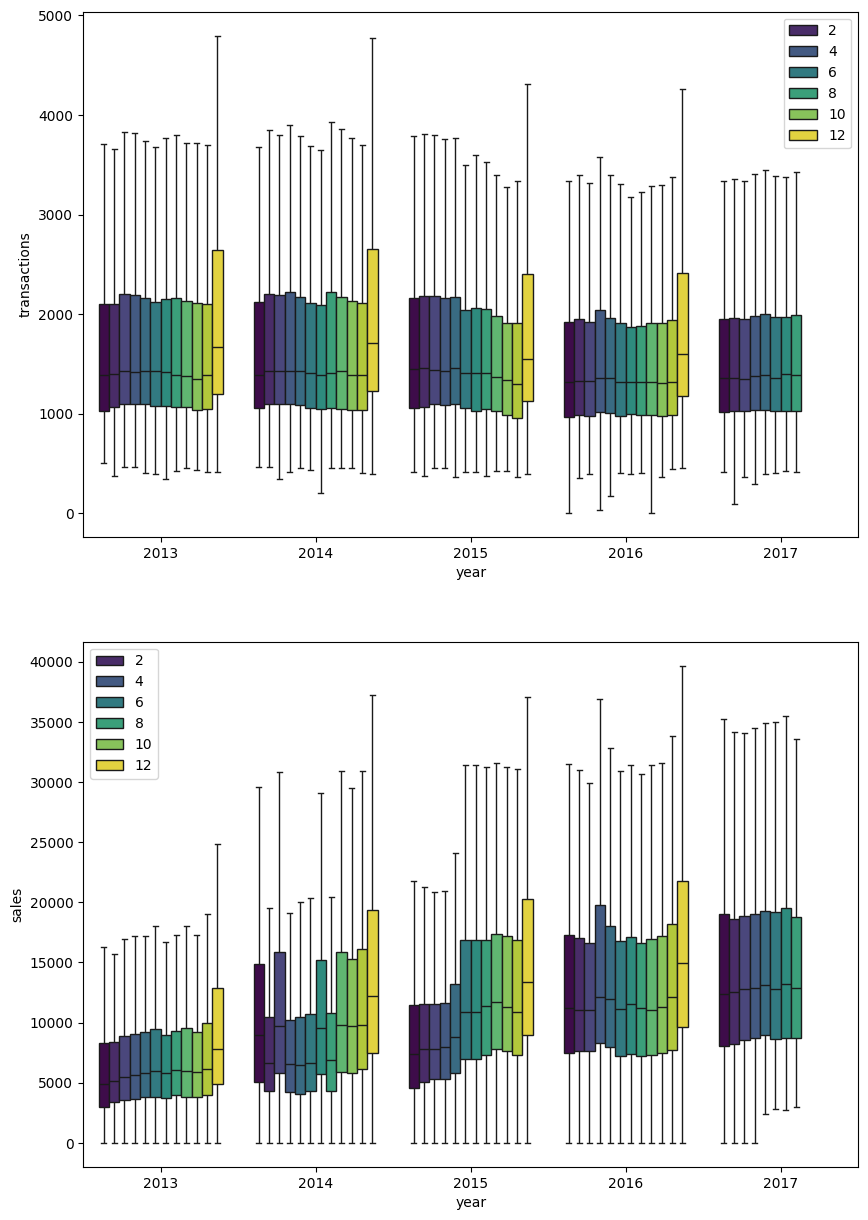

In [143]:


fig, axes = plt.subplots(nrows = 2, ncols = 1 , figsize=(10, 15))

sns.boxplot( data = sales_vs_transact_df,
            x = "year",
            y = "transactions",
            hue = "month",
            palette= "viridis",
            showfliers=False,
            ax = axes[0] )
axes[0].legend()

sns.boxplot( data = sales_vs_transact_df,
            x = "year",
            y = "sales",
            hue = "month",
            palette= "viridis",
            showfliers=False,
            ax = axes[1] )
axes[1].legend()

plt.show()





In [144]:
transactions_df.head()


date  store_nbr  transactions
0 2013-01-01         25           770
1 2013-01-02          1          2111
2 2013-01-02          2          2358
3 2013-01-02          3          3487
4 2013-01-02          4          1922

In [145]:
monthly = transactions_df.set_index("date").resample("M").transactions.mean().reset_index()
monthly.head()
# put date as new index
# regroup data by month
# compute the mean of transactions by group (month)
# then reset index, which means date will not be the index anymore

# second way to do it
transactions_df_2 = transactions_df.copy()
transactions_df_2["year_month"] = transactions_df_2["date"].dt.strftime(date_format="%Y-%m")
monthly2 = transactions_df_2.groupby("year_month").transactions.mean()
monthly2.head(10) # same 10 rows as monthly

/tmp/ipython-input-3744811603.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = transactions_df.set_index("date").resample("M").transactions.mean().reset_index()


year_month
2013-01    1657.898624
2013-02    1684.483696
2013-03    1724.181627
2013-04    1699.206522
2013-05    1702.874396
2013-06    1701.426743
2013-07    1675.012552
2013-08    1689.182567
2013-09    1688.270922
2013-10    1653.013040
Name: transactions, dtype: float64

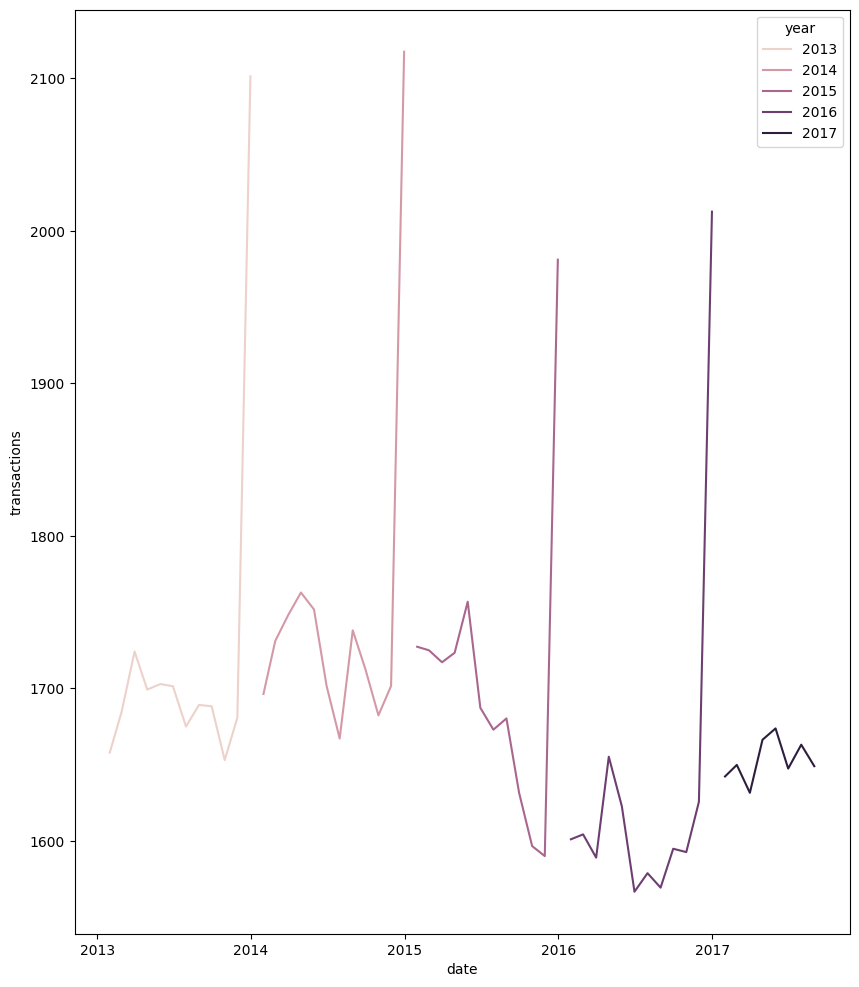

In [146]:
# plot

monthly["year"] = monthly["date"].dt.year
plt.figure(figsize = (10,12))
sns.lineplot(data = monthly, x = "date", y = "transactions", hue = "year" )
plt.show()

In [147]:
sales_vs_transact_df.head()


date  store_nbr  sales  transactions year_month  year  month
0 2013-01-01          1    0.0           NaN    2013-01  2013      1
1 2013-01-01          2    0.0           NaN    2013-01  2013      1
2 2013-01-01          3    0.0           NaN    2013-01  2013      1
3 2013-01-01          4    0.0           NaN    2013-01  2013      1
4 2013-01-01          5    0.0           NaN    2013-01  2013      1

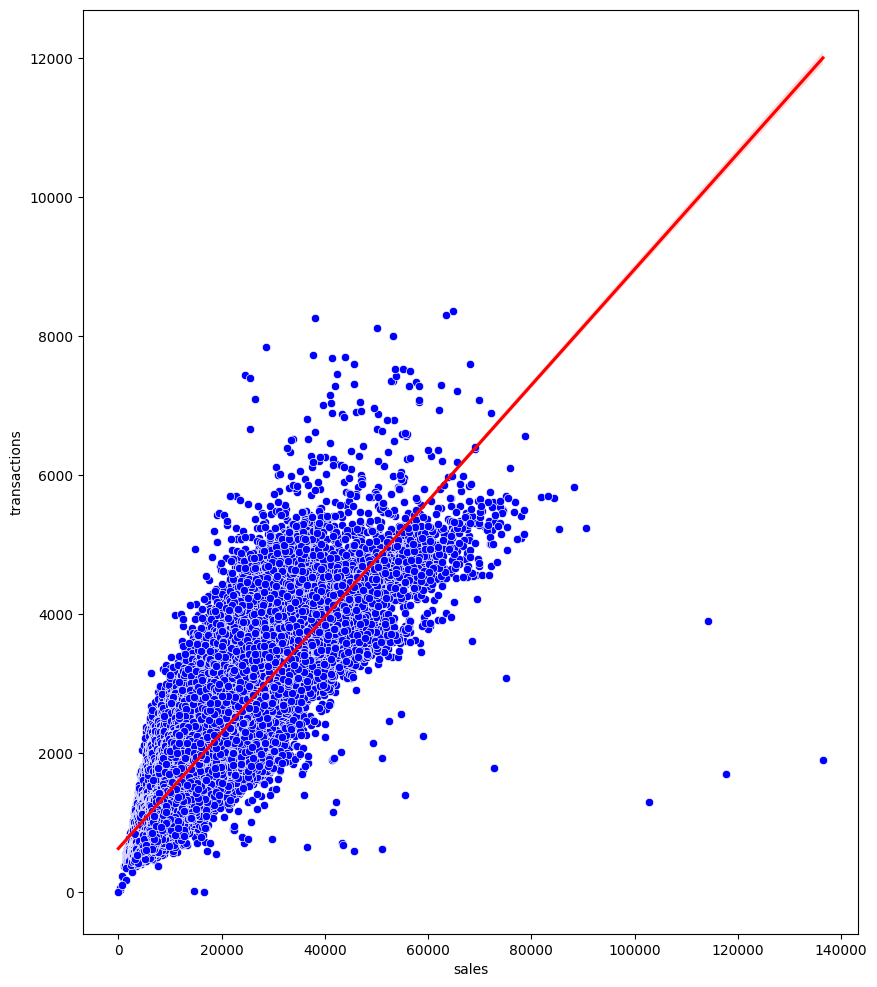

In [148]:
# Let's plot the scatterplot between sales and transactions

plt.figure(figsize= (10,12))
sns.scatterplot( data=sales_vs_transact_df, x="sales", y= "transactions", color ="blue")
sns.regplot(data=sales_vs_transact_df, x="sales", y= "transactions",scatter = False, color = "red")
plt.show()

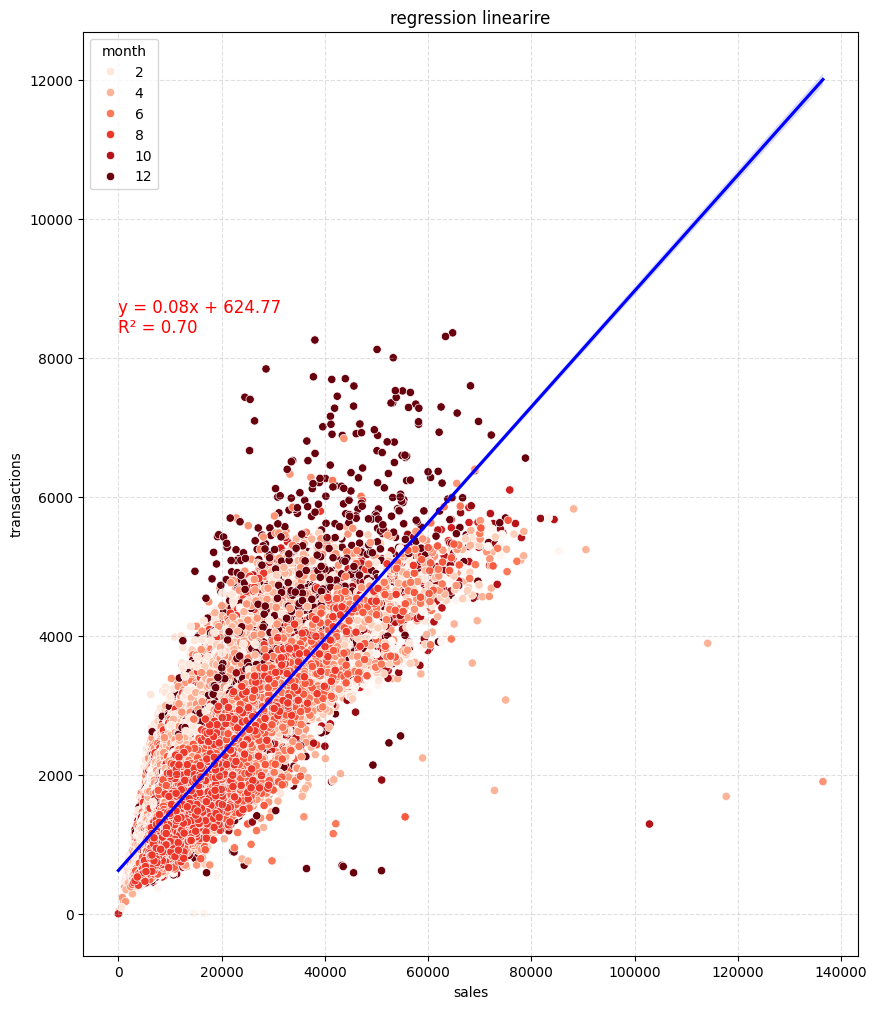

In [149]:

# let's add value of regression line
from scipy.stats import linregress

# Drop na
df_clean = sales_vs_transact_df[["sales", "transactions", "month"]].dropna()

# compute linear regression coefficients
slope, intercept, r_value, p_value, std_err = linregress(df_clean["sales"], df_clean["transactions"])

plt.figure(figsize=(10, 12))
sns.scatterplot(data=df_clean, x="sales", y="transactions", palette="Reds", hue = "month")
sns.regplot(data=df_clean, x="sales", y="transactions", scatter=False, color="blue")

# Affichage des coefficients sur le graphique
plt.text(
    x=df_clean["sales"].min(),
    y=df_clean["transactions"].max(), # x, y positions
    s=f"y = {slope:.2f}x + {intercept:.2f}\nR² = {r_value**2:.2f}", # texte en lui meme
    fontsize=12,
    color="red"
)
plt.title("regression linearire")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

# we can see the correlation, but also the fact that for december, transactions are really higher.



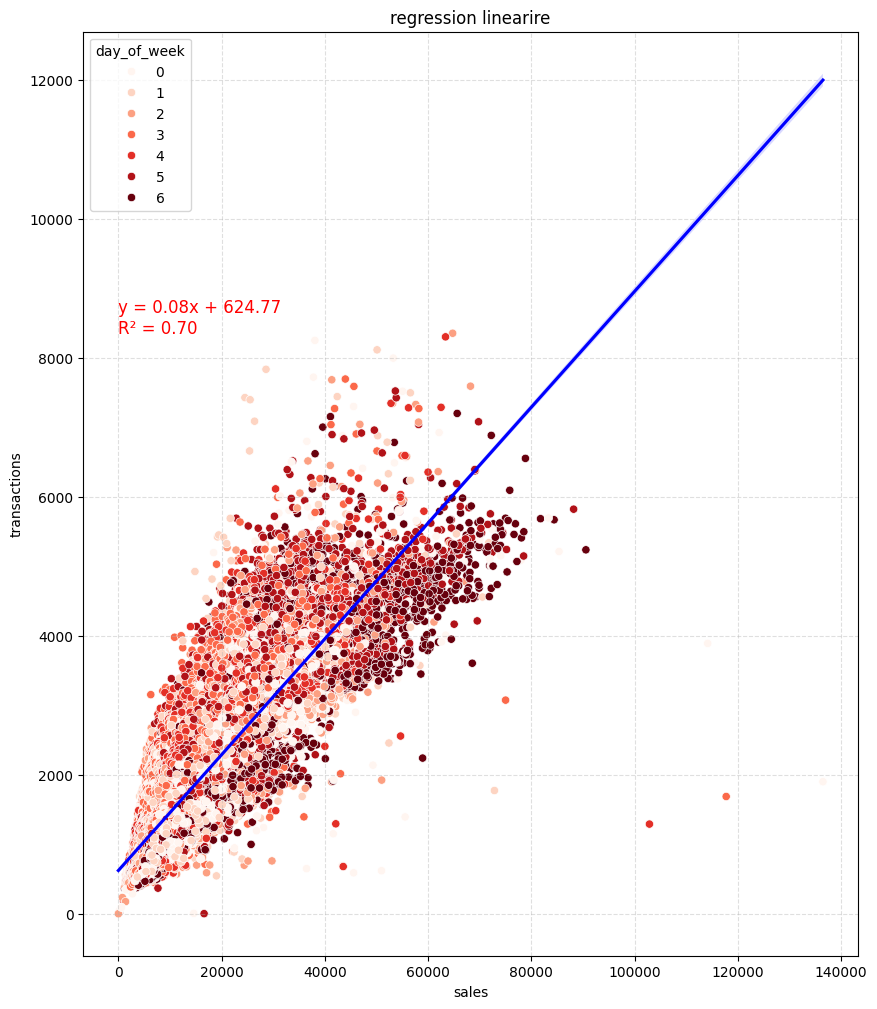

In [150]:
# let's work on the day of the weeks
sales_vs_transact_df

sales_vs_transact_df["day_of_week"] = sales_vs_transact_df["date"].dt.day_of_week
sales_vs_transact_df.head(100)


# Drop na
df_clean = sales_vs_transact_df[["sales", "transactions", "day_of_week"]].dropna() # monday = 0, sunday = 6

# compute linear regression coefficients
slope, intercept, r_value, p_value, std_err = linregress(df_clean["sales"], df_clean["transactions"])

plt.figure(figsize=(10, 12))
sns.scatterplot(data=df_clean, x="sales", y="transactions", palette="Reds", hue = "day_of_week")
sns.regplot(data=df_clean, x="sales", y="transactions", scatter=False, color="blue")

# Affichage des coefficients sur le graphique
plt.text(
    x=df_clean["sales"].min(),
    y=df_clean["transactions"].max(), # x, y positions
    s=f"y = {slope:.2f}x + {intercept:.2f}\nR² = {r_value**2:.2f}", # texte en lui meme
    fontsize=12,
    color="red"
)
plt.title("regression linearire")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()



/tmp/ipython-input-4177671457.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data = sales_vs_transact_df, x = "day_of_week", y = "transactions", hue = "year", palette = "bright", ci = None, ax= axes[2] )
/tmp/ipython-input-4177671457.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data = sales_vs_transact_df, x = "day_of_week", y = "transactions", hue = "month", palette = "bright", ci = None, ax= axes[3] )
/tmp/ipython-input-4177671457.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data = sales_vs_transact_df, x = "year_month", y = "transactions", hue = "day_of_week", palette = "bright", ci = None, ax = axes[4] )
/tmp/ipython-input-4177671457.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data = sales_vs_transact_df, x = "

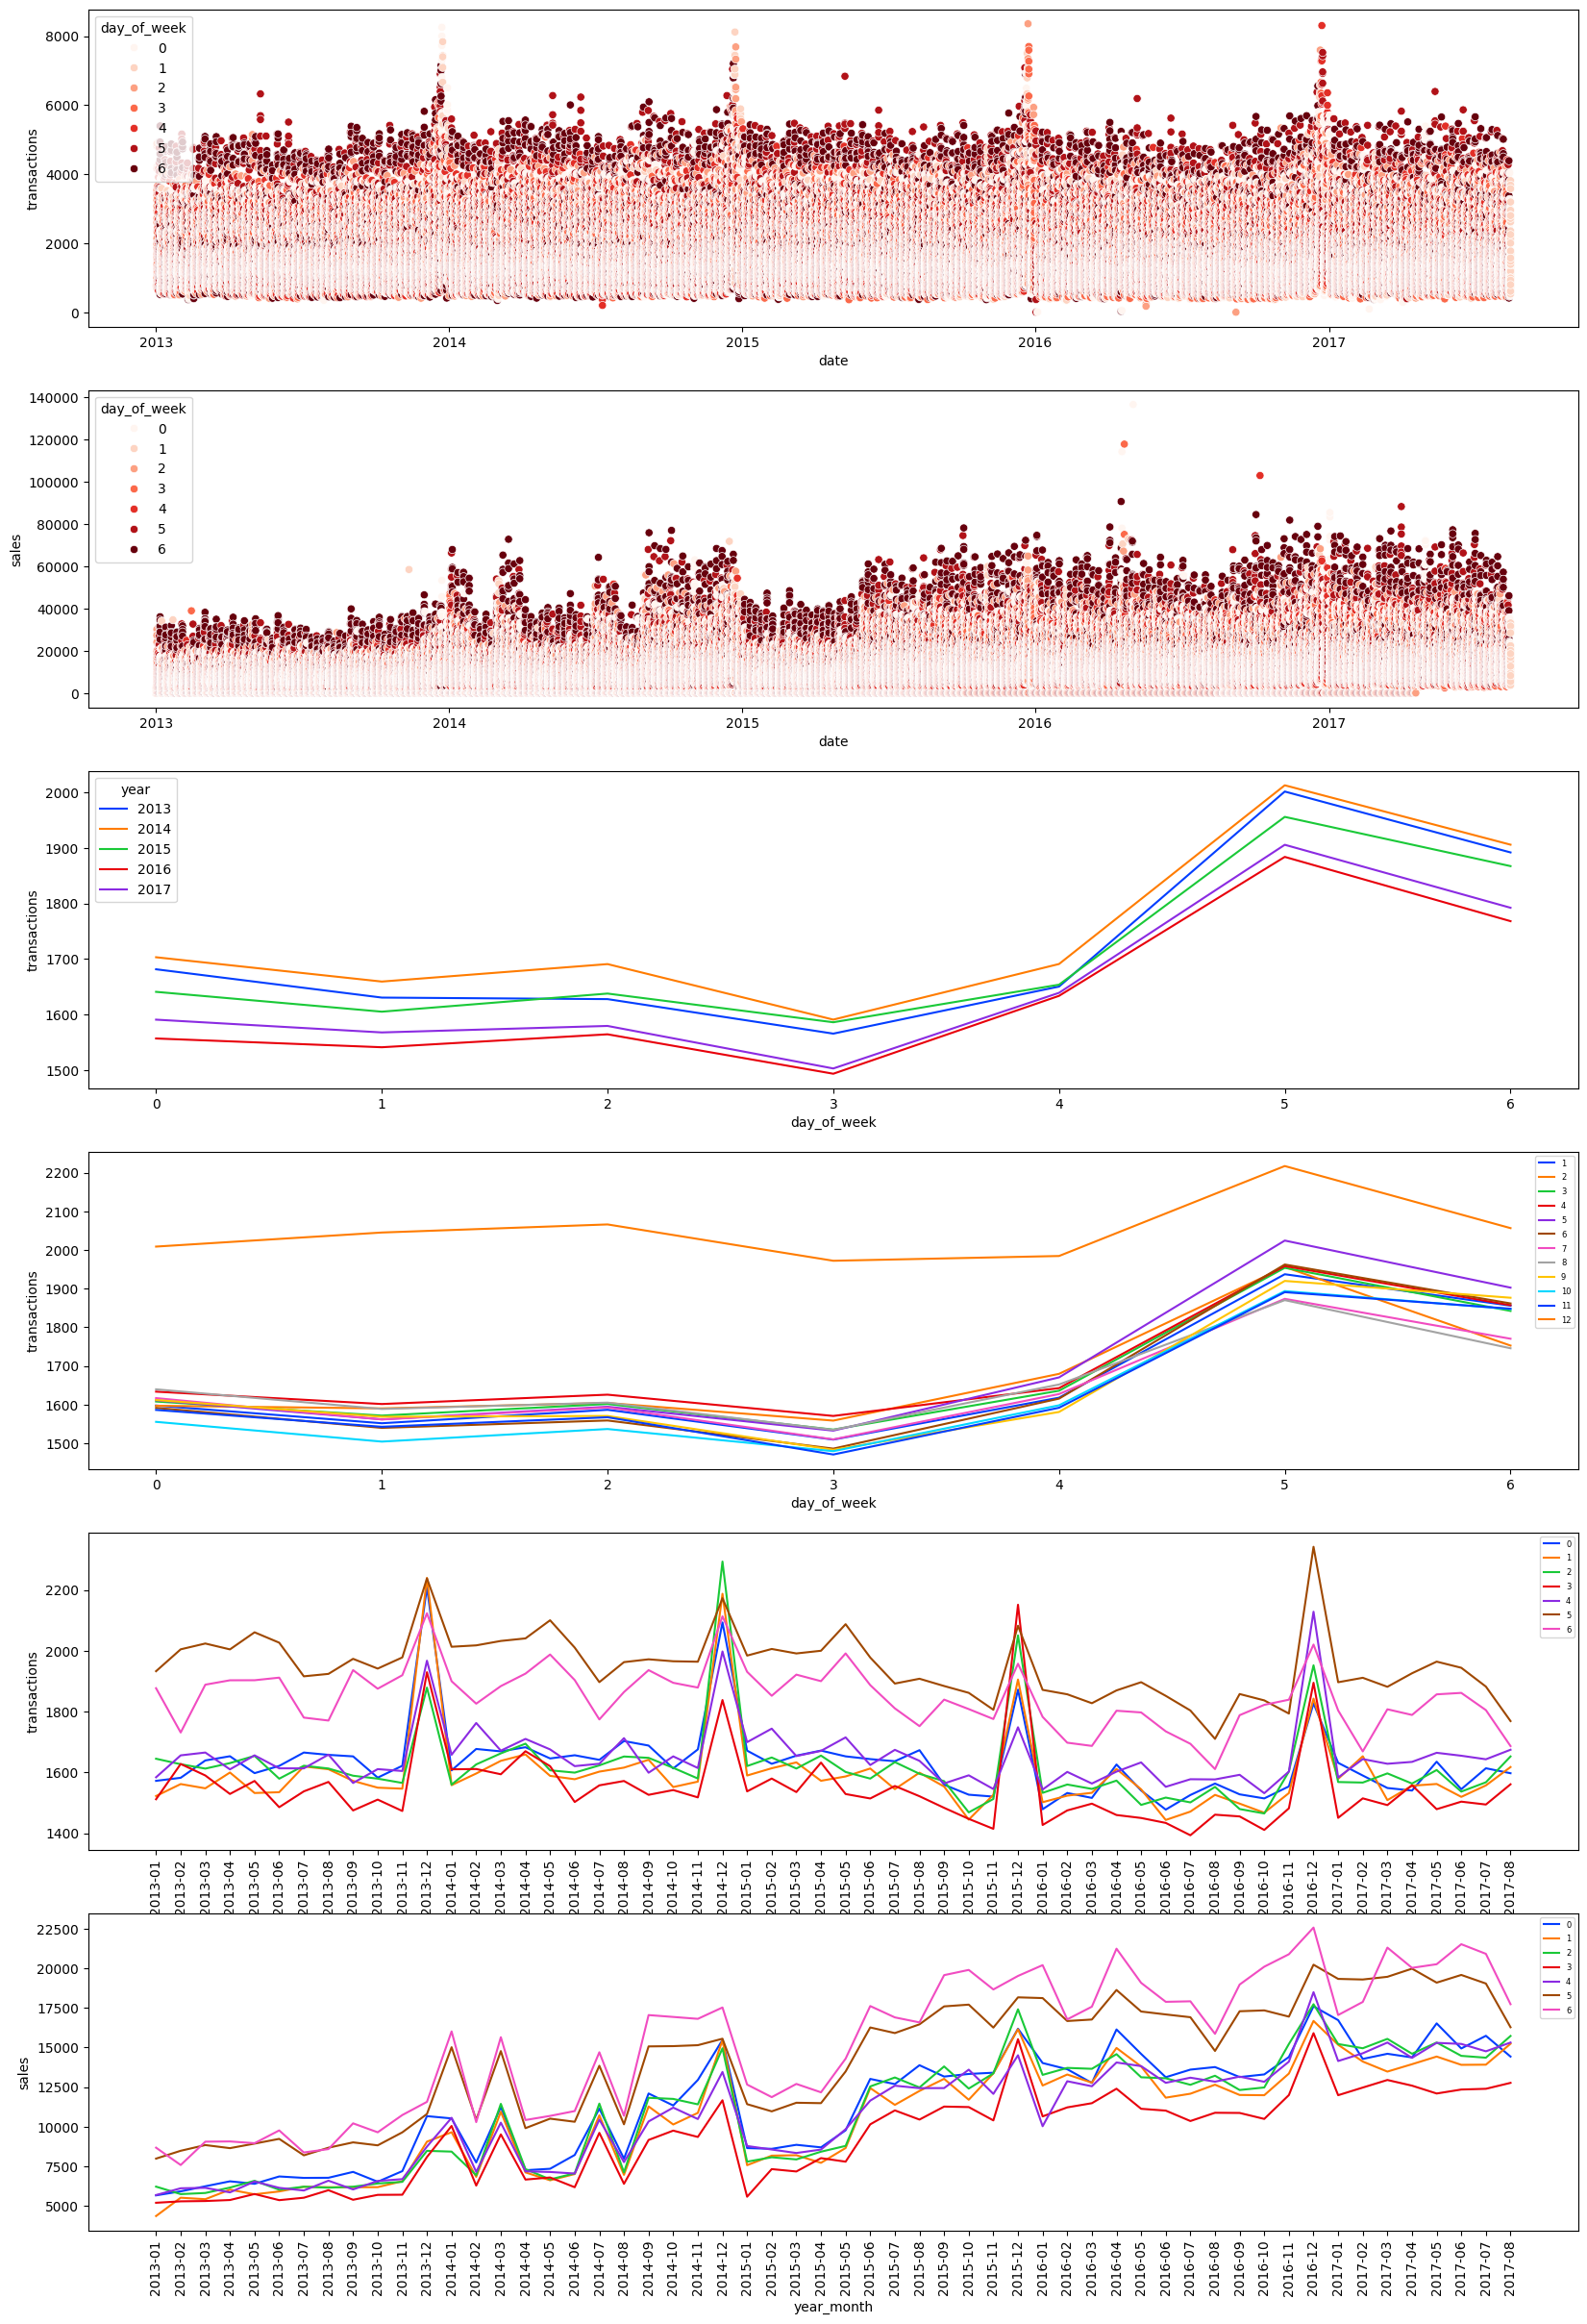

In [151]:
fig, axes = plt.subplots(ncols = 1, nrows = 6, figsize = (20, 30) )
sns.scatterplot(data = sales_vs_transact_df, x = "date", y= "transactions", hue = "day_of_week" , ax=axes[0], palette = "Reds")
sns.scatterplot(data = sales_vs_transact_df, x = "date", y= "sales", hue = "day_of_week" , ax=axes[1], palette = "Reds")
sns.lineplot(data = sales_vs_transact_df, x = "day_of_week", y = "transactions", hue = "year", palette = "bright", ci = None, ax= axes[2] )
sns.lineplot(data = sales_vs_transact_df, x = "day_of_week", y = "transactions", hue = "month", palette = "bright", ci = None, ax= axes[3] )
axes[3].legend(fontsize=6,title_fontsize=10, labelspacing=0.7)
sns.lineplot(data = sales_vs_transact_df, x = "year_month", y = "transactions", hue = "day_of_week", palette = "bright", ci = None, ax = axes[4] )
axes[4].tick_params(axis='x', rotation=90)
axes[4].legend(fontsize=6,title_fontsize=10, labelspacing=0.7)
sns.lineplot(data = sales_vs_transact_df, x = "year_month", y = "sales", hue = "day_of_week", palette = "bright", ci = None, ax = axes[5] )
axes[5].tick_params(axis='x', rotation=90)
axes[5].legend(fontsize=6,title_fontsize=10, labelspacing=0.7)
plt.show()


# Oil

In [152]:
nan_index = oil_df.loc[oil_df["dcoilwtico"].isna()].index
nan_index

Index([   0,   14,   34,   63,  104,  132,  174,  237,  256,  261,  274,  294,
        338,  364,  393,  434,  497,  517,  522,  534,  554,  588,  624,  653,
        699,  757,  778,  783,  794,  814,  843,  889,  914,  959, 1017, 1039,
       1044, 1054, 1079, 1118, 1149, 1174, 1175],
      dtype='int64')

In [153]:
import numpy as np
# first we need to resample to have one value per day (some days have no value)
oil_df = oil_df.set_index("date").dcoilwtico.resample("D").sum().reset_index()
oil_df["dcoilwtico"] = np.where(oil_df["dcoilwtico"] == 0, np.nan, oil_df["dcoilwtico"]) #replace if (condition, when true, when false)


# let's see if we have missing values

oil_df.isna().sum() # 43 missing for dcoilwtico (before resampling), 486 after resampling

# As we are with time data here, we have several options to impute missing values:
# 1/ ffill/bfill
# 2/ interpolate
# 3/ with a model (SimpleImputer)

# I think here a bfill or interpolation is a very solid option

oil_df["dcoilwtico"] = oil_df["dcoilwtico"].fillna(method="bfill")

/tmp/ipython-input-3121182246.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  oil_df["dcoilwtico"] = oil_df["dcoilwtico"].fillna(method="bfill")


In [154]:
oil_df.isna().sum() # 0
# combined_index = nan_index.union(nan_index + 1).union(nan_index - 1)
# oil_df.iloc[combined_index]

date          0
dcoilwtico    0
dtype: int64

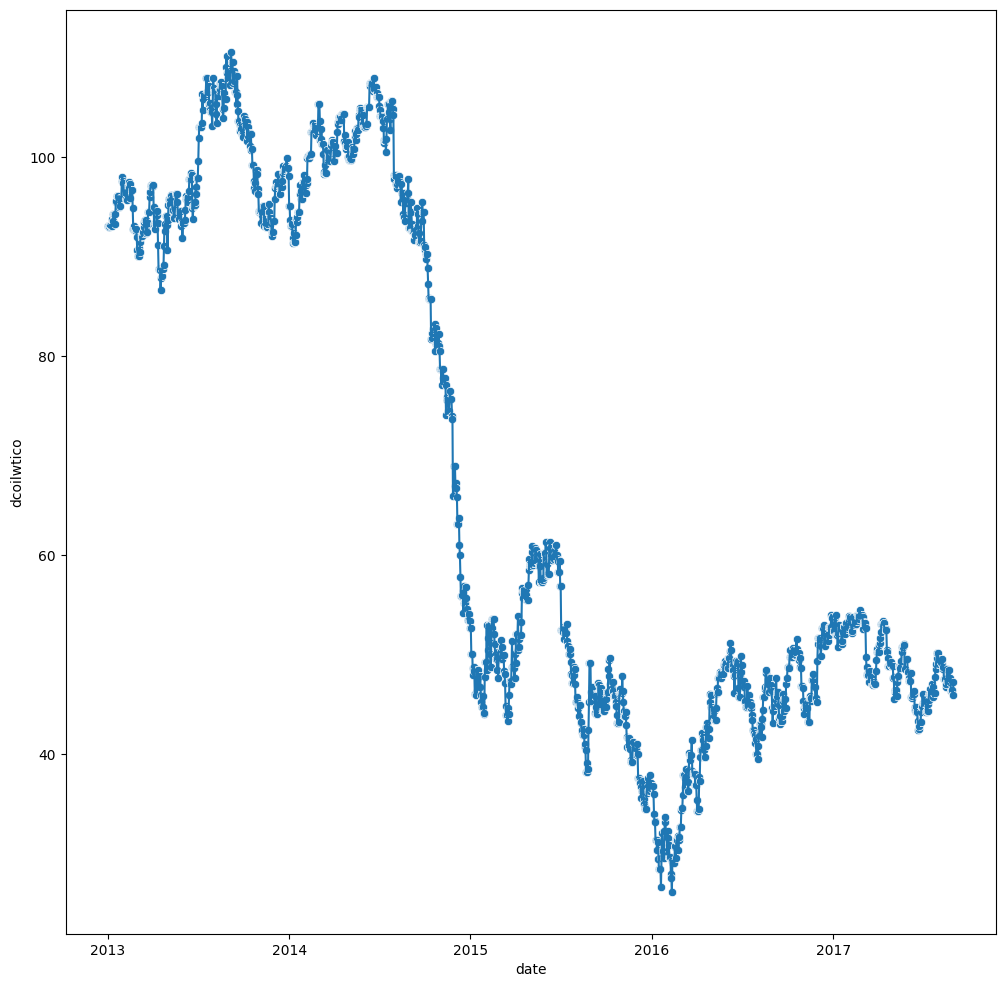

In [155]:
import matplotlib.dates as mdates


plt.figure(figsize=(12,12))
sns.scatterplot( data =oil_df, x="date", y="dcoilwtico" )
sns.lineplot( data =oil_df, x="date", y="dcoilwtico" )
# Afficher uniquement les années sur l'axe X
plt.gca().xaxis.set_major_locator(mdates.YearLocator())# une graduation par an
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))# format AAAA
plt.show()

spearman correlation bewteen transactions and oil: 0.03978692096584637
spearman correlation bewteen sales and oil: -0.3040770690004285
pearson correlation bewteen transactions and oil: 0.026210122316853587
pearson correlation bewteen sales and oil: -0.27492396451937945


/tmp/ipython-input-3635221596.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


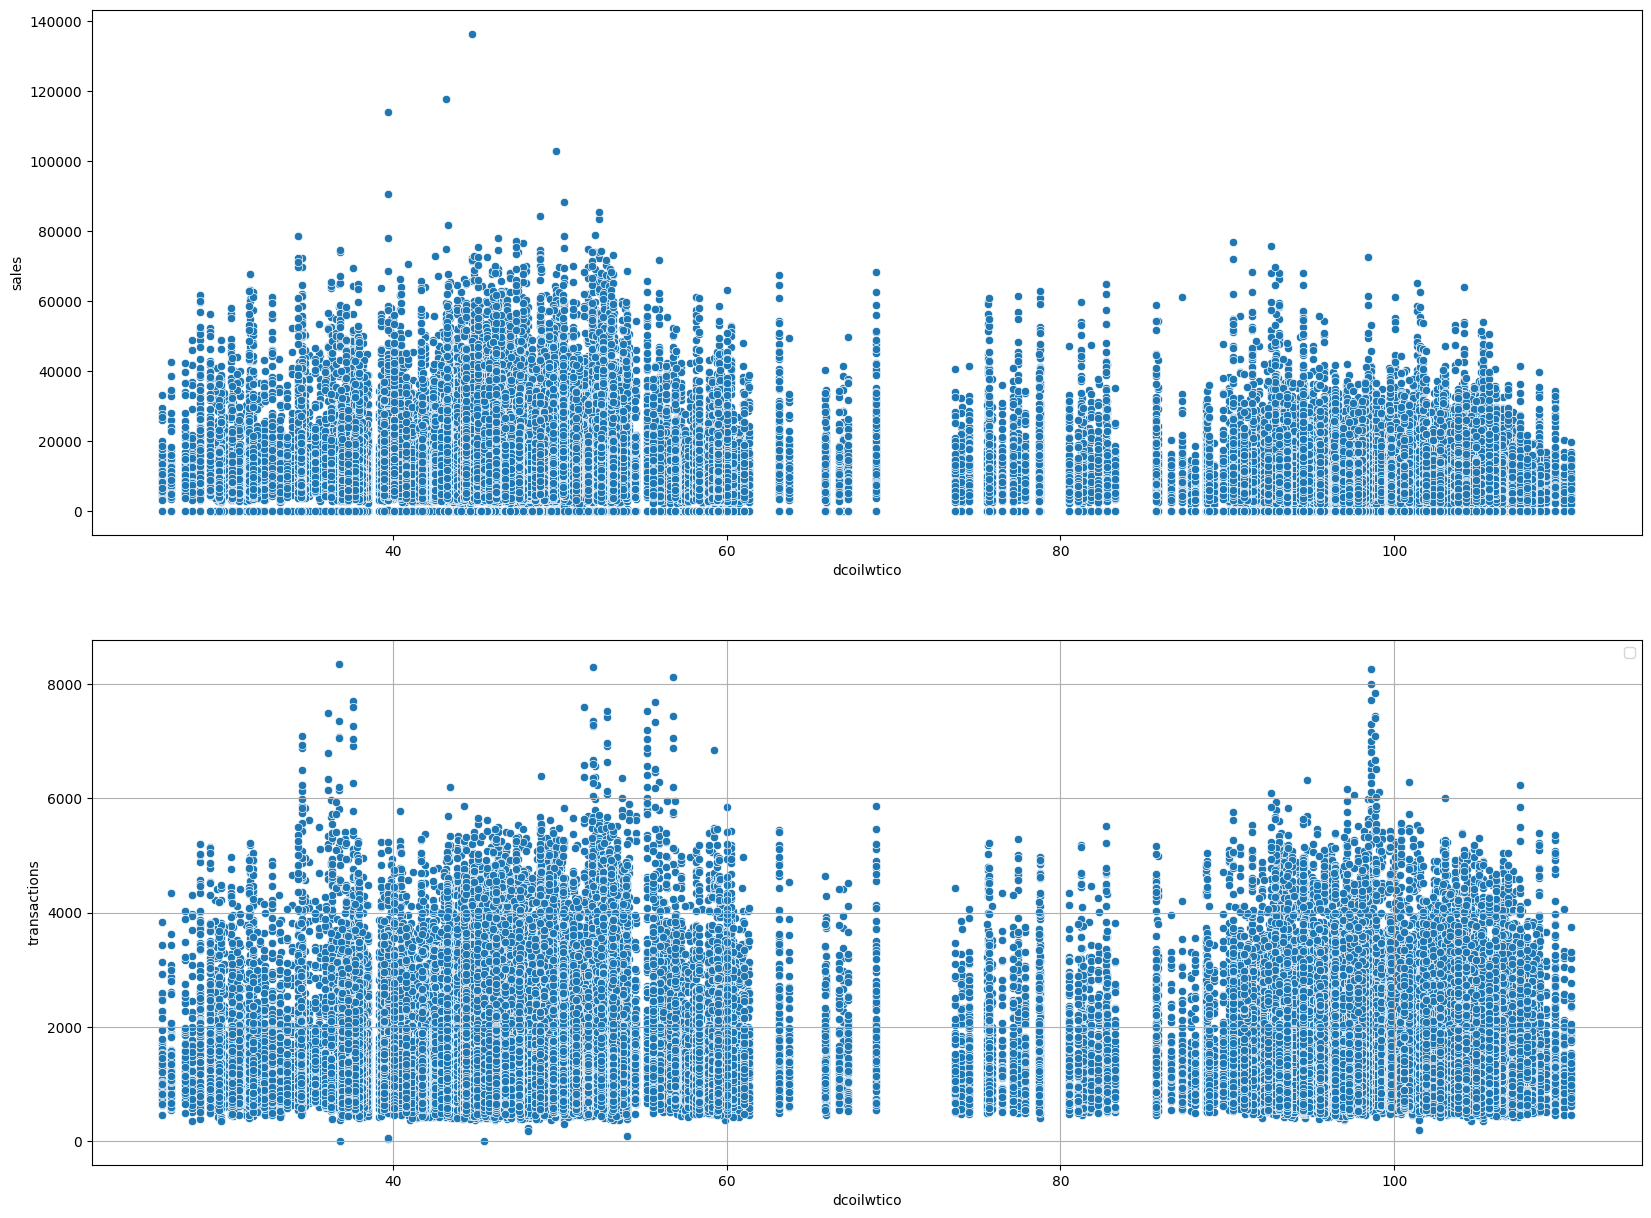

In [156]:
# Let's plot transactionsales vs oil price

# merge

oil_df # 2013-01-01 -> 2017-08-31
sales_vs_transact_df#2013-01-01 -> 2017-08-15

merged_df = pd.merge(left = sales_vs_transact_df, right = oil_df, how = "left", on = "date")
merged_df

# person / spearman correlations
print(f'spearman correlation bewteen transactions and oil: {merged_df["transactions"].corr(merged_df["dcoilwtico"], method="spearman")}')
print(f'spearman correlation bewteen sales and oil: {merged_df["sales"].corr(merged_df["dcoilwtico"], method="spearman")}')
print(f'pearson correlation bewteen transactions and oil: {merged_df["transactions"].corr(merged_df["dcoilwtico"], method="pearson")}')
print(f'pearson correlation bewteen sales and oil: {merged_df["sales"].corr(merged_df["dcoilwtico"], method="pearson")}')

# spearman correlation bewteen transactions and oild: 0.03978692096584637
# spearman correlation bewteen sales and oild: -0.3040770690004285
# pearson correlation bewteen transactions and oild: 0.026210122316853608
# pearson correlation bewteen sales and oild: -0.27492396451937906

fig, axes = plt.subplots(ncols=1, nrows = 2, figsize=(20,15))
sns.scatterplot(data =merged_df, y="sales", x="dcoilwtico", ax =axes[0])
sns.scatterplot(data =merged_df, y="transactions", x="dcoilwtico", ax =axes[1])
# sns.scatterplot(data =merged_df, x=, y=, ax =, hue=)
# sns.scatterplot(data =merged_df, x=, y=, ax =, hue=)
plt.legend()
plt.grid()
plt.show(True)





We don't see a lot of correlation on this brut data.
Let's include family product

In [157]:
train_df

# group  sales by family and day
grouped_train = train_df.groupby(["date","family"])["sales"].sum().reset_index()
grouped_train

# merge with daily oil price
merged_sales_family_oil = pd.merge(left = grouped_train, right = oil_df, how = "left", on = "date")
merged_sales_family_oil

# compute correlation between sales and oild price for each family
corr_sales_family_oil = merged_sales_family_oil.groupby("family").corr("spearman").reset_index() # compute corr between all vars (corr matrix) by family
# level_1 contains the name of the variable involved in the correlation
# we filter only when level_1 == sales and keep the dataset with family and oilprice for this filter
# so we get the global correlation between oilprice and sales for each family
corr_sales_family_oil = corr_sales_family_oil[corr_sales_family_oil["level_1"] == "sales"][["family","dcoilwtico"]].sort_values(by = "dcoilwtico")
corr_sales_family_oil


family  dcoilwtico
49         HOME AND KITCHEN II   -0.787343
70                   MAGAZINES   -0.719641
46          HOME AND KITCHEN I   -0.641517
94  SCHOOL AND OFFICE SUPPLIES   -0.624176
79                PET SUPPLIES   -0.621457
4                    BABY CARE   -0.619157
10                   BEVERAGES   -0.615809
19                 CELEBRATION   -0.613547
82     PLAYERS AND ELECTRONICS   -0.580862
55                   HOME CARE   -0.574215
91                     PRODUCE   -0.571264
7                       BEAUTY   -0.545206
25                       DAIRY   -0.535648
16                BREAD/BAKERY   -0.528257
58                  LADIESWEAR   -0.511478
28                        DELI   -0.476050
37                   GROCERY I   -0.475595
76               PERSONAL CARE   -0.454550
61             LAWN AND GARDEN   -0.440731
1                   AUTOMOTIVE   -0.440421
22                    CLEANING   -0.391305
88              PREPARED FOODS   -0.362432
43                    HARDWARE   -0.360313
85                     POULTRY   -0.350412
34                FROZEN FOODS   -0.336716
31                        EGGS   -0.322772
97                     SEAFOOD   -0.236992
40                  GROCERY II   -0.220486
13                       BOOKS   -0.205064
67            LIQUOR,WINE,BEER   -0.189466
73                       MEATS   -0.131923
52             HOME APPLIANCES    0.087901
64                    LINGERIE    0.419133

In [158]:
merged_sales_family_oil[merged_sales_family_oil["family"] == "HOME AND KITCHEN II"]

date               family   sales  dcoilwtico
16    2013-01-01  HOME AND KITCHEN II     0.0       93.14
49    2013-01-02  HOME AND KITCHEN II     0.0       93.14
82    2013-01-03  HOME AND KITCHEN II     0.0       92.97
115   2013-01-04  HOME AND KITCHEN II     0.0       93.12
148   2013-01-05  HOME AND KITCHEN II     0.0       93.20
...          ...                  ...     ...         ...
55423 2017-08-11  HOME AND KITCHEN II  1504.0       48.81
55456 2017-08-12  HOME AND KITCHEN II  1504.0       47.59
55489 2017-08-13  HOME AND KITCHEN II  1625.0       47.59
55522 2017-08-14  HOME AND KITCHEN II  1668.0       47.59
55555 2017-08-15  HOME AND KITCHEN II  1448.0       47.57

[1684 rows x 4 columns]

In [159]:
familia ="HOME AND KITCHEN II"
corr_sales_family_oil[corr_sales_family_oil.family==familia]["dcoilwtico"].iloc[0]

np.float64(-0.7873432722416696)

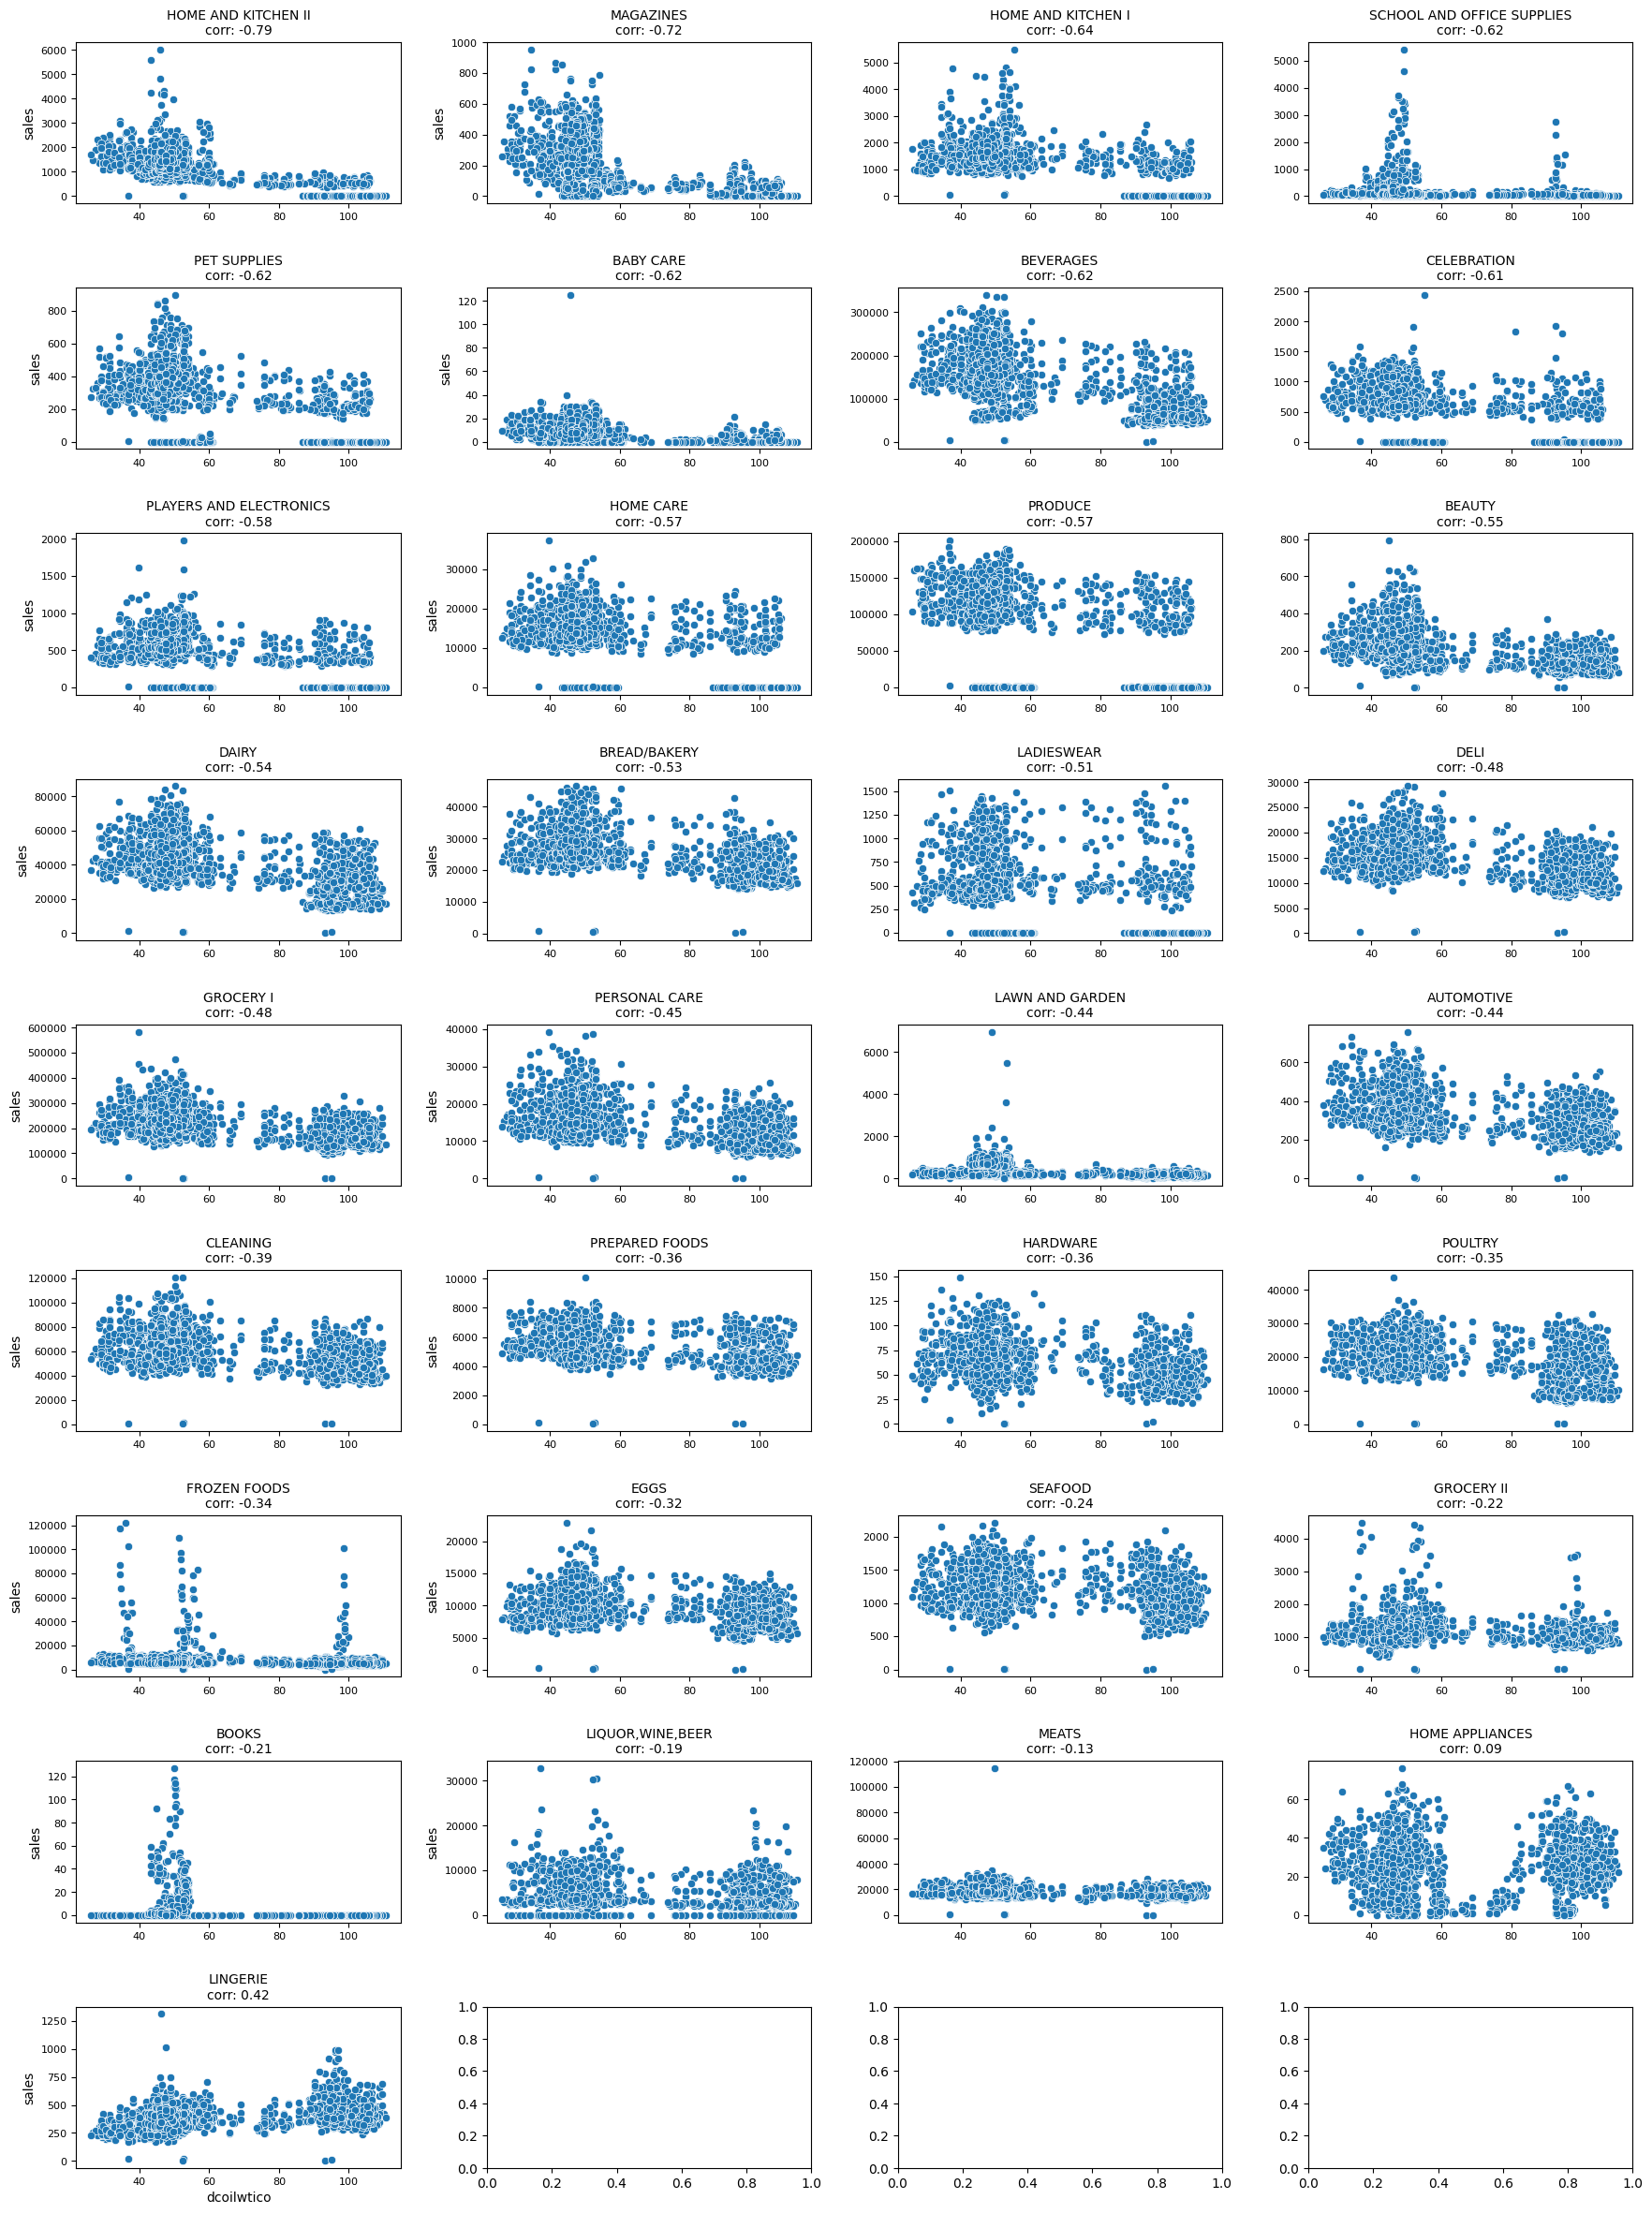

In [160]:
rows = 9
cols = 4
fig, axes = plt.subplots(ncols=cols, nrows=rows, figsize=(18, 24))

for i, familia in enumerate(corr_sales_family_oil["family"]):
    row = i // cols
    col = i % cols

    df_fam = merged_sales_family_oil[merged_sales_family_oil["family"] == familia]
    ax = axes[row, col]
    sns.scatterplot(data=df_fam, x="dcoilwtico", y="sales", ax=ax)

    corr_value = corr_sales_family_oil[corr_sales_family_oil["family"] == familia]["dcoilwtico"].iloc[0]
    ax.set_title(f'{familia}\ncorr: {corr_value:.2f}', fontsize=10)
    ax.tick_params(labelsize=8)

    # Enlève les labels redondants
    if row < rows - 1:
        ax.set_xlabel("")
    if col > 1:
        ax.set_ylabel("")

plt.tight_layout(pad=2.0, h_pad=2.5, w_pad=2.0)
plt.show()






In [161]:
train_df

id       date  store_nbr                      family     sales  \
0              0 2013-01-01          1                  AUTOMOTIVE     0.000   
1              1 2013-01-01          1                   BABY CARE     0.000   
2              2 2013-01-01          1                      BEAUTY     0.000   
3              3 2013-01-01          1                   BEVERAGES     0.000   
4              4 2013-01-01          1                       BOOKS     0.000   
...          ...        ...        ...                         ...       ...   
3000883  3000883 2017-08-15          9                     POULTRY   438.133   
3000884  3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885 2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
3000883            0  
3000884            1  
3000885          148  
3000886            8  
3000887            0  

[3000888 rows x 6 columns]

In [162]:
# Let's compute the correlation among stores

train_filter = train_df[["date","store_nbr", "sales"]]
pivoted_train = train_filter.pivot_table( index = "date", columns = "store_nbr", values = "sales")
cor_mat = pivoted_train.corr()
cor_mat





store_nbr        1         2         3         4         5         6   \
store_nbr                                                               
1          1.000000  0.367043  0.452200  0.304566  0.346422  0.246452   
2          0.367043  1.000000  0.768286  0.758834  0.627174  0.753501   
3          0.452200  0.768286  1.000000  0.957932  0.790787  0.953582   
4          0.304566  0.758834  0.957932  1.000000  0.806466  0.974002   
5          0.346422  0.627174  0.790787  0.806466  1.000000  0.792956   
6          0.246452  0.753501  0.953582  0.974002  0.792956  1.000000   
7          0.790859  0.647381  0.808575  0.710914  0.605044  0.681316   
8          0.491183  0.758022  0.980651  0.939287  0.781293  0.929821   
9          0.157747  0.671437  0.850300  0.871988  0.725461  0.908468   
10         0.195569  0.605646  0.768021  0.789694  0.745251  0.818811   
11         0.253773  0.642358  0.808685  0.811843  0.724115  0.835160   
12         0.410471  0.598124  0.746585  0.713164  0.632706  0.722318   
13         0.392737  0.517071  0.656021  0.607571  0.590577  0.627862   
14         0.475984  0.507294  0.638391  0.567367  0.559298  0.590312   
15         0.645140  0.582688  0.714613  0.640433  0.618456  0.639743   
16        -0.030551  0.474176  0.592929  0.661745  0.757210  0.682634   
17         0.308847  0.697205  0.872509  0.860947  0.640260  0.889535   
18         0.165850  0.514776  0.612253  0.622633  0.528370  0.646366   
19         0.416529  0.624301  0.795158  0.749717  0.678960  0.763823   
20         0.294065  0.572395  0.687867  0.639803  0.392993  0.668323   
21         0.390271  0.551308  0.712245  0.649233  0.397967  0.665607   
22         0.444502  0.517596  0.637876  0.569575  0.337981  0.584979   
23         0.509491  0.683062  0.868377  0.847598  0.772397  0.837786   
24         0.631228  0.553635  0.711036  0.627945  0.599697  0.599318   
25         0.169372  0.232707  0.317714  0.298488  0.381557  0.299259   
26         0.157906  0.389168  0.501693  0.531067  0.629608  0.525272   
27         0.280795  0.711577  0.911770  0.911125  0.760108  0.924686   
28         0.171631  0.663895  0.833323  0.850739  0.719503  0.878168   
29         0.416359  0.567503  0.718290  0.649923  0.419617  0.669349   
30         0.478888  0.574665  0.699773  0.654967  0.633822  0.660549   
31         0.290495  0.653081  0.808717  0.813280  0.816748  0.823776   
32         0.306242  0.439129  0.546969  0.538719  0.511177  0.545842   
33         0.297337  0.634550  0.785944  0.798183  0.842324  0.807314   
34         0.398149  0.590953  0.735941  0.718916  0.795961  0.716821   
35         0.236227  0.413053  0.525557  0.508843  0.465372  0.514686   
36         0.451420  0.591780  0.741024  0.696003  0.651134  0.697879   
37         0.743793  0.614478  0.787520  0.709254  0.754221  0.675818   
38         0.301689  0.673794  0.875502  0.875245  0.837771  0.879614   
39         0.374201  0.636908  0.803638  0.778003  0.640608  0.792754   
40         0.565368  0.651324  0.815761  0.747256  0.699878  0.751026   
41         0.375763  0.700904  0.903241  0.884013  0.807367  0.887269   
42         0.487809  0.561237  0.717512  0.639852  0.365572  0.647290   
43         0.375164  0.606985  0.776495  0.741003  0.696795  0.760554   
44         0.347680  0.738428  0.958518  0.941508  0.773585  0.940740   
45         0.280459  0.738355  0.948187  0.940560  0.792487  0.957811   
46         0.077711  0.671971  0.871258  0.905751  0.775763  0.933243   
47         0.255965  0.736091  0.956040  0.956871  0.792596  0.972318   
48        -0.000093  0.648956  0.840393  0.889497  0.759919  0.921625   
49         0.515703  0.749193  0.963315  0.908504  0.747657  0.905803   
50         0.247483  0.698202  0.913850  0.913372  0.812154  0.931737   
51         0.526979  0.713449  0.913842  0.866701  0.825892  0.847135   
52         0.148774  0.137586  0.204493  0.146177  0.113698  0.179970   
53         0.459616  0.613153  0.753678  0.705299  0.56830

In [163]:

a = train_df[["store_nbr", "sales"]]
a["ind"] = 1
a["ind"] = a.groupby("store_nbr").ind.cumsum().values
a = pd.pivot(a, index = "ind", columns = "store_nbr", values = "sales").corr()
a



/tmp/ipython-input-507055851.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a["ind"] = 1
/tmp/ipython-input-507055851.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a["ind"] = a.groupby("store_nbr").ind.cumsum().values


store_nbr        1         2         3         4         5         6   \
store_nbr                                                               
1          1.000000  0.749028  0.903203  0.875326  0.861080  0.850448   
2          0.749028  1.000000  0.810965  0.826477  0.795537  0.824199   
3          0.903203  0.810965  1.000000  0.977034  0.909736  0.963789   
4          0.875326  0.826477  0.977034  1.000000  0.949025  0.987992   
5          0.861080  0.795537  0.909736  0.949025  1.000000  0.954317   
6          0.850448  0.824199  0.963789  0.987992  0.954317  1.000000   
7          0.951409  0.770493  0.959602  0.918595  0.854954  0.889457   
8          0.911239  0.811326  0.992653  0.976025  0.913614  0.960580   
9          0.754952  0.771334  0.852773  0.912437  0.932070  0.940693   
10         0.726495  0.732820  0.782455  0.859723  0.921177  0.893419   
11         0.775606  0.765092  0.845230  0.897874  0.931174  0.927038   
12         0.764576  0.745012  0.810530  0.866063  0.903262  0.896761   
13         0.747912  0.722042  0.780329  0.840112  0.895913  0.872466   
14         0.748352  0.714022  0.761062  0.826708  0.895644  0.856139   
15         0.815585  0.755729  0.824511  0.877258  0.931172  0.899948   
16         0.732336  0.728889  0.804412  0.869145  0.936794  0.892030   
17         0.795056  0.789864  0.889810  0.929407  0.916929  0.954846   
18         0.780171  0.755741  0.873513  0.890236  0.872472  0.900186   
19         0.772781  0.752603  0.835044  0.876991  0.904481  0.908316   
20         0.535302  0.593180  0.631221  0.656602  0.595149  0.684858   
21         0.593079  0.596589  0.680729  0.693570  0.615798  0.715028   
22         0.565073  0.569479  0.611779  0.635792  0.577624  0.663182   
23         0.880319  0.792450  0.920108  0.941815  0.934816  0.941673   
24         0.912788  0.766360  0.928537  0.912933  0.884507  0.896782   
25         0.729854  0.638106  0.782637  0.766866  0.757125  0.764365   
26         0.658407  0.630723  0.714044  0.754737  0.792838  0.766478   
27         0.861974  0.808847  0.972209  0.974327  0.922979  0.970965   
28         0.773142  0.781536  0.894280  0.930544  0.918592  0.950642   
29         0.655170  0.644053  0.739215  0.745622  0.669195  0.765574   
30         0.807975  0.754640  0.847047  0.880221  0.903942  0.899338   
31         0.778691  0.766922  0.856286  0.907231  0.943845  0.927157   
32         0.661541  0.640298  0.693254  0.752688  0.799104  0.777720   
33         0.811452  0.778173  0.872651  0.920693  0.962166  0.934137   
34         0.798649  0.760023  0.847257  0.891798  0.937069  0.915718   
35         0.625997  0.608814  0.682010  0.716318  0.732287  0.735482   
36         0.815851  0.767844  0.874811  0.899690  0.902146  0.913989   
37         0.942738  0.798058  0.947573  0.950731  0.952418  0.937992   
38         0.847020  0.793008  0.923864  0.952321  0.957896  0.954081   
39         0.754381  0.726214  0.823218  0.856482  0.860960  0.873483   
40         0.808179  0.766286  0.848801  0.890891  0.921117  0.915141   
41         0.845051  0.796608  0.928660  0.953113  0.943555  0.956013   
42         0.694025  0.624200  0.758194  0.731253  0.609960  0.726103   
43         0.778157  0.748038  0.859841  0.879823  0.884016  0.907023   
44         0.880166  0.802830  0.985406  0.970277  0.904710  0.957115   
45         0.847609  0.817237  0.964325  0.975804  0.933012  0.980785   
46         0.760258  0.788513  0.898388  0.946050  0.937292  0.968401   
47         0.847338  0.819306  0.971107  0.985224  0.943055  0.990681   
48         0.720147  0.773640  0.870264  0.928026  0.927329  0.955233   
49         0.900074  0.801361  0.985492  0.961727  0.886078  0.945763   
50         0.815641  0.801015  0.914865  0.956483  0.962523  0.974291   
51         0.917078  0.796466  0.978298  0.957614  0.913092  0.939191   
52         0.272703  0.226135  0.288689  0.267704  0.242116  0.276325   
53         0.758736  0.705770  0.827694  0.827284  0.76297

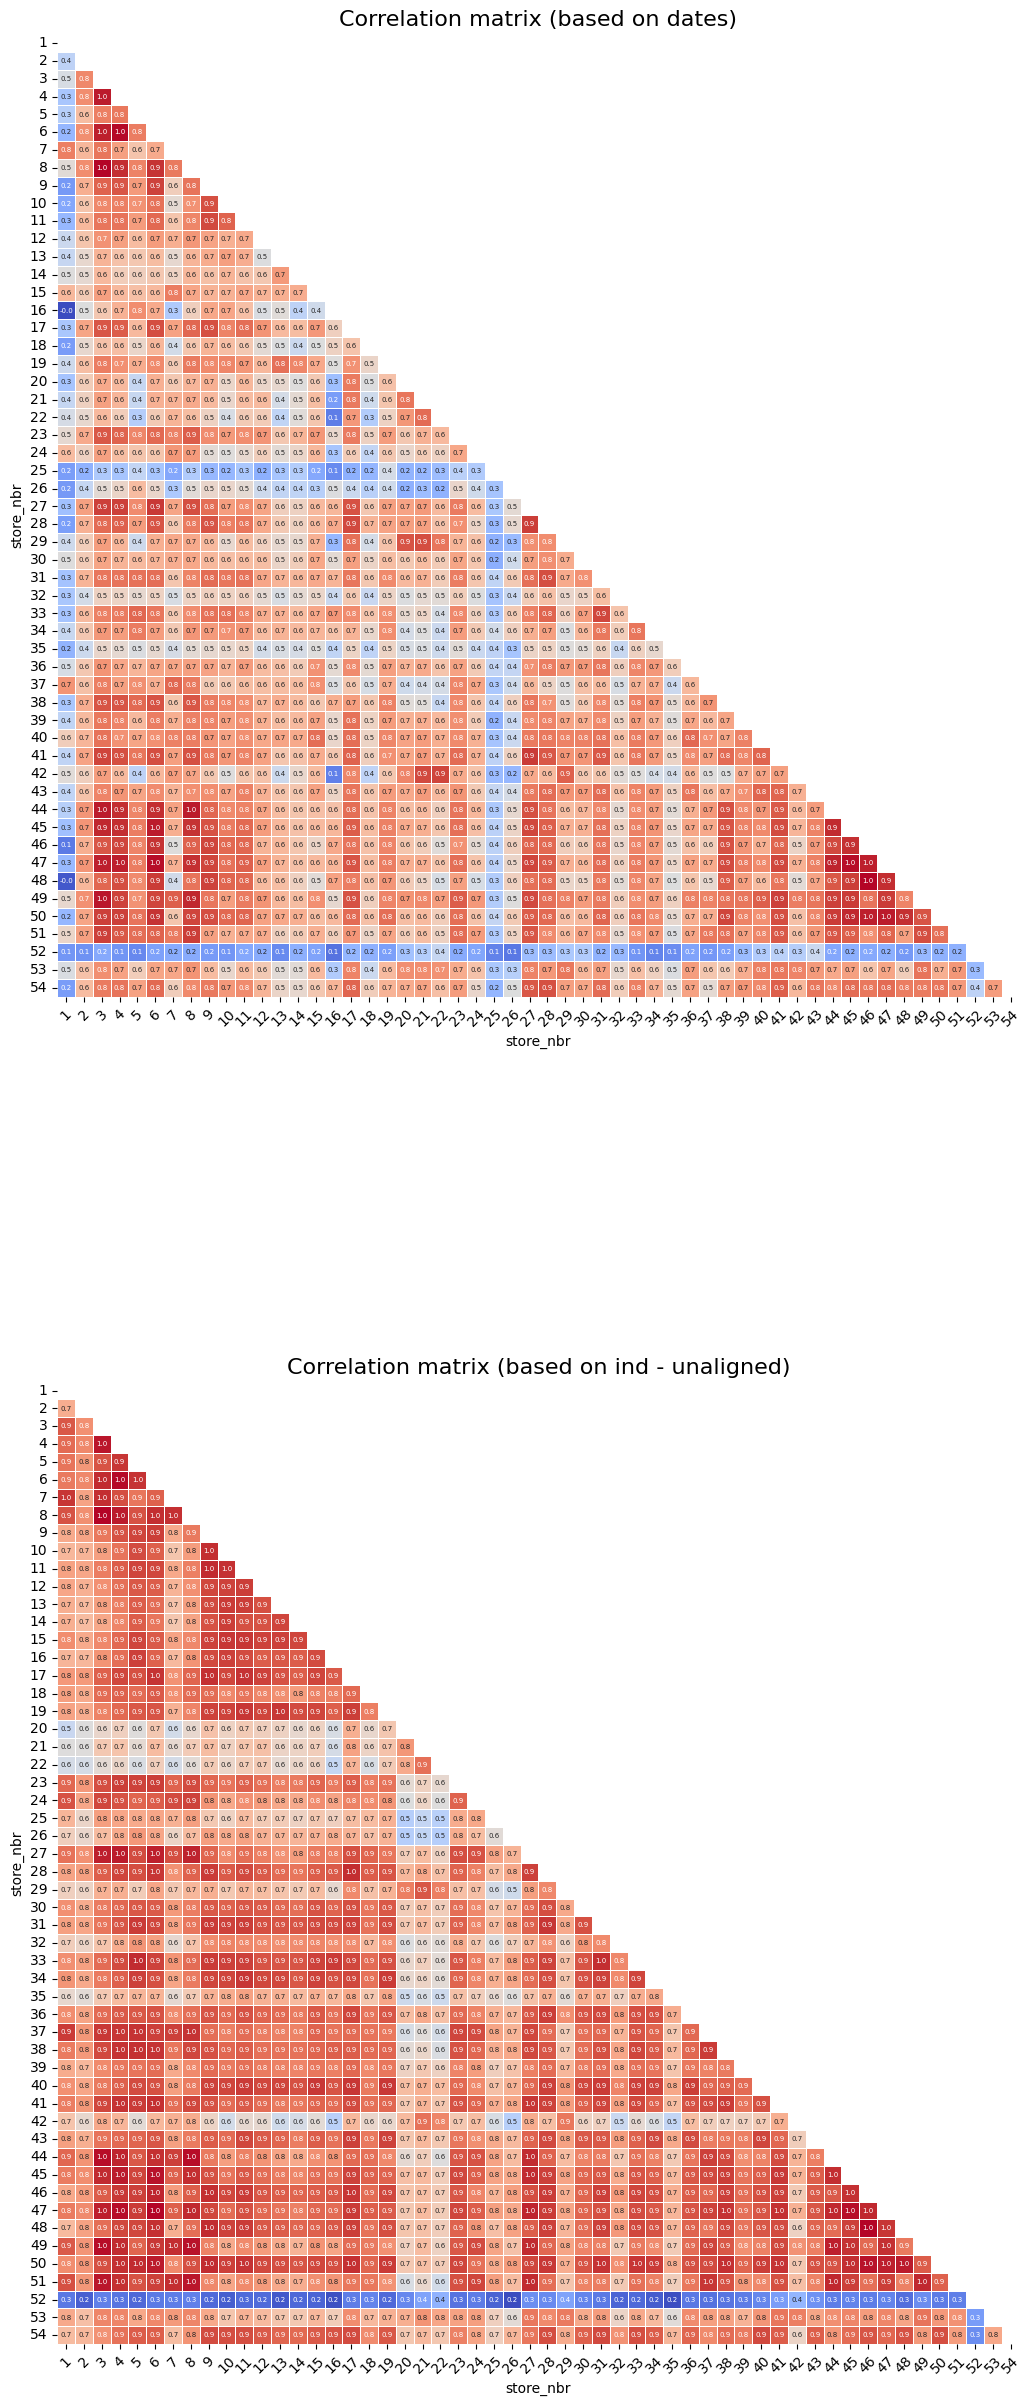

In [164]:
# a, cor_mat
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Créer un masque triangulaire
mask = np.triu(np.ones_like(cor_mat, dtype=bool))

# Créer la figure
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(15, 30))

sns.heatmap(data=cor_mat,
            ax=axes[0],
            mask=mask,
            annot=True,
            fmt='.1f',
            cmap="coolwarm",
            square=True,
            linewidths=0.5,
            annot_kws={"size": 5},
            cbar=False)
axes[0].set_title("Correlation matrix (based on dates)", fontsize=16)
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

sns.heatmap(data=a,
            ax=axes[1],
            mask=mask,
            annot=True,
            fmt='.1f',
            cmap="coolwarm",
            square=True,
            linewidths=0.5,
            annot_kws={"size": 5},
            cbar=False)
axes[1].set_title("Correlation matrix (based on ind - unaligned)", fontsize=16)
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=0)

plt.subplots_adjust(hspace=0.4)
plt.show()


In [165]:
pivot_ind = train_df[["store_nbr", "sales"]].copy()
pivot_ind["ind"] = pivot_ind.groupby("store_nbr").cumcount() + 1
pivot_by_ind = pivot_ind.pivot(index="ind", columns="store_nbr", values="sales")

pivot_by_date = train_df.pivot_table(index="date", columns="store_nbr", values="sales")

print("Number of rows per pivot:")
print(f"By ind: {pivot_by_ind.shape[0]}")
print(f"By date: {pivot_by_date.shape[0]}")


Number of rows per pivot:
By ind: 55572
By date: 1684


In [166]:
train_df.head()

id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0

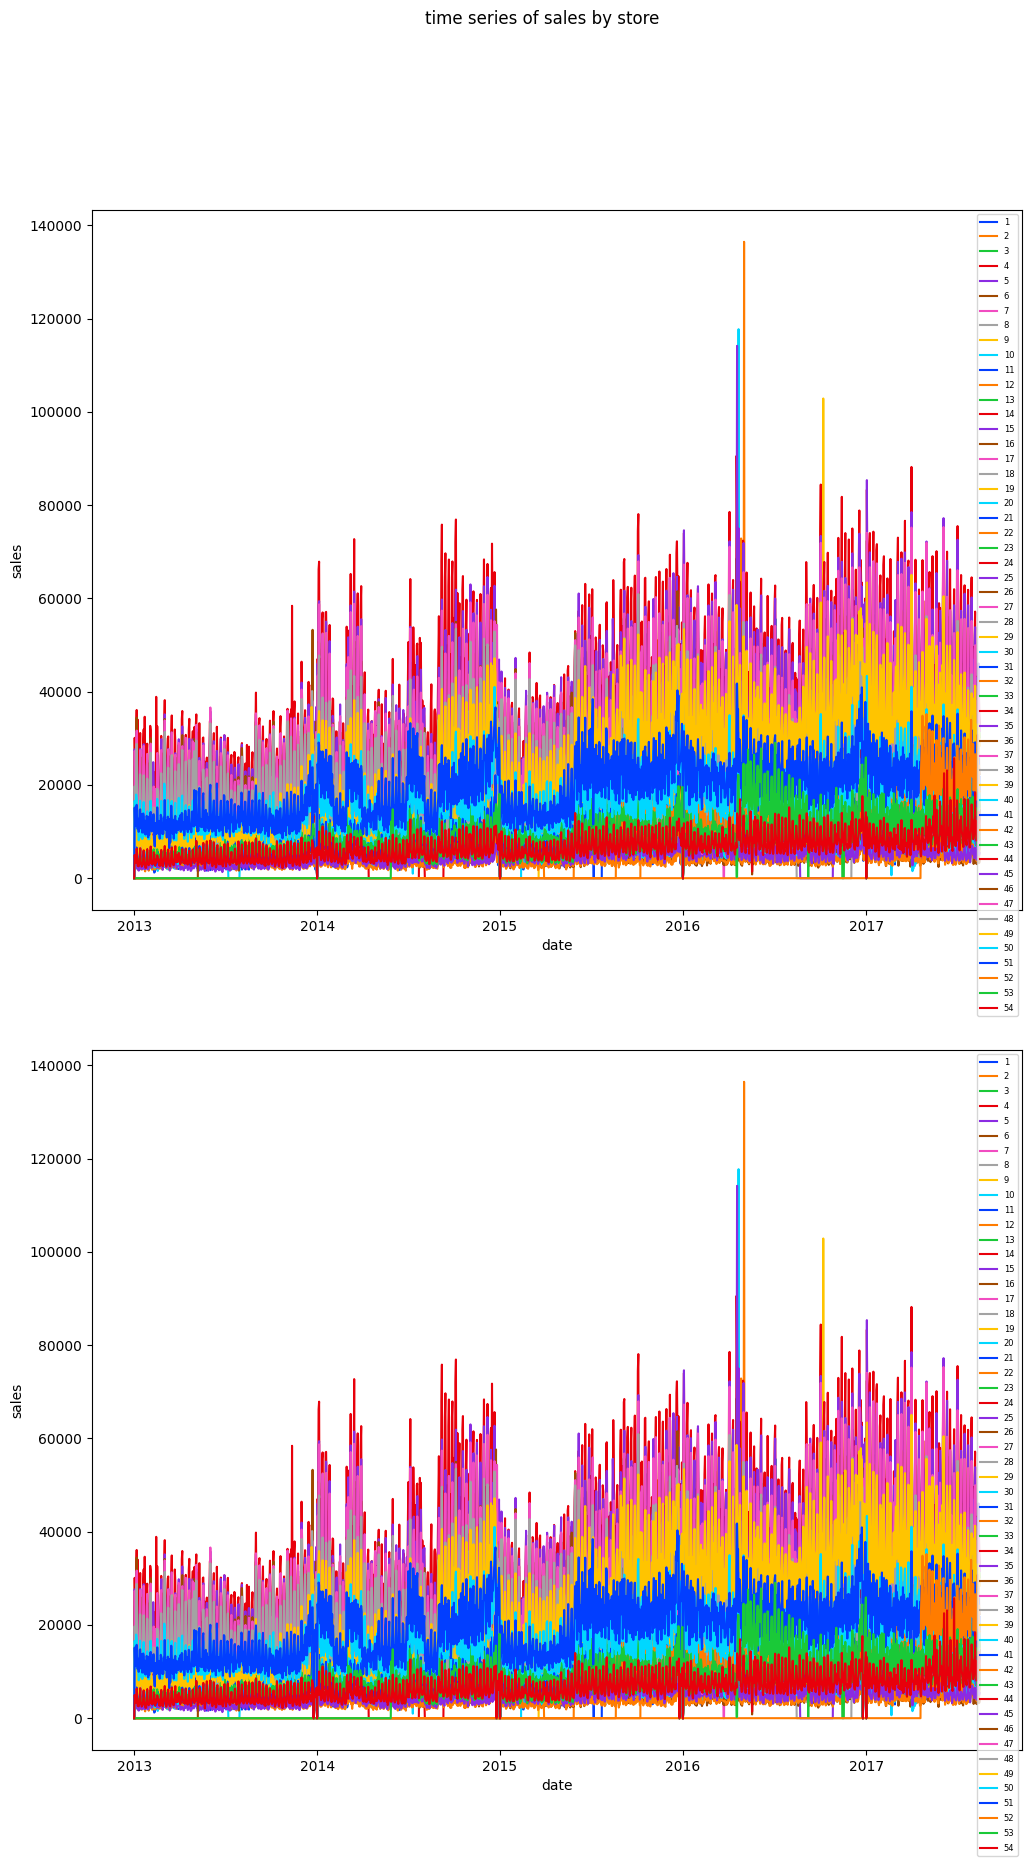

In [167]:
# let's plot sales by store nbr

sales_by_store = train_df.groupby(["date","store_nbr"]).sales.sum().reset_index()
sales_by_store

sales_by_store_2 = train_df.set_index("date").groupby("store_nbr").resample("D").sales.sum().reset_index()
sales_by_store_2

# plot

fig, axes = plt. subplots(ncols = 1, nrows = 2, figsize = (12,20))
sns.lineplot(data = sales_by_store, x= "date", y="sales", hue = "store_nbr", palette = "bright", ax = axes[0])
axes[0].legend(fontsize=6,title_fontsize=10, labelspacing=0.7)
sns.lineplot(data = sales_by_store_2, x= "date", y="sales", hue = "store_nbr", palette = "bright", ax = axes[1] )
axes[1].legend(fontsize=6,title_fontsize=10, labelspacing=0.7)
fig.suptitle("time series of sales by store")
plt.show()


In [168]:
sales_by_store

date  store_nbr         sales
0     2013-01-01          1      0.000000
1     2013-01-01          2      0.000000
2     2013-01-01          3      0.000000
3     2013-01-01          4      0.000000
4     2013-01-01          5      0.000000
...          ...        ...           ...
90931 2017-08-15         50  16879.121004
90932 2017-08-15         51  20154.559000
90933 2017-08-15         52  18600.046000
90934 2017-08-15         53   8208.189000
90935 2017-08-15         54  12666.858000

[90936 rows x 3 columns]

In [169]:
# let's find stores day of opening

a =train_df[train_df["sales"]>0].groupby("store_nbr")["date"].min()
a

train_df_corrected = pd.merge(left = train_df, right = a, how = "left",  on = "store_nbr")
print("before : ",train_df_corrected.shape)
train_df_corrected = train_df_corrected[ train_df_corrected["date_x"]> train_df_corrected["date_y"]  ]
print("after : ",train_df_corrected.shape)
train_df_corrected.drop(columns="date_y", inplace=True)
train_df_corrected.rename(columns= {"date_x" : "date"}, inplace = True)
train_df_corrected

# before :  (3000888, 7)
# after :  (2777049, 7)



before :  (3000888, 7)
after :  (2777049, 7)


id       date  store_nbr                      family     sales  \
2343        2343 2013-01-02         25                  AUTOMOTIVE     0.000   
2344        2344 2013-01-02         25                   BABY CARE     0.000   
2345        2345 2013-01-02         25                      BEAUTY     4.000   
2346        2346 2013-01-02         25                   BEVERAGES  1373.000   
2347        2347 2013-01-02         25                       BOOKS     0.000   
...          ...        ...        ...                         ...       ...   
3000883  3000883 2017-08-15          9                     POULTRY   438.133   
3000884  3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885 2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  
2343               0  
2344               0  
2345               0  
2346               0  
2347               0  
...              ...  
3000883            0  
3000884            1  
3000885          148  
3000886            8  
3000887            0  

[2777049 rows x 6 columns]

In [170]:
# products that ar'nt sell in some stores

a = train_df_corrected.groupby(["store_nbr","family"]).sales.sum().reset_index()
a = a[a["sales"] == 0]
a # datasets with combinason store/prduct family that arn't sold

# antijoin
print("before", train_df_corrected.shape)
outer_join = train_df_corrected.merge(a.drop("sales",axis = 1), how = 'outer', indicator = True) # drop sales from a, irrelevant
# and merge it with train_corrected
# indactor = leftonly, right_only or both
outer_join[outer_join["_merge"] == "both"]
train_df_corrected = outer_join[~(outer_join["_merge"] == "both")].drop(columns = ["_merge"])
print("after", train_df_corrected.shape)



before (2777049, 6)
after (2695478, 6)


In [171]:
outer_join[outer_join["_merge"] == "right_only"]
# empty, logique car outter provient de train_df

a


store_nbr           family  sales
1             1        BABY CARE    0.0
268           9            BOOKS    0.0
301          10            BOOKS    0.0
334          11            BOOKS    0.0
367          12            BOOKS    0.0
397          13        BABY CARE    0.0
400          13            BOOKS    0.0
433          14            BOOKS    0.0
449          14  LAWN AND GARDEN    0.0
466          15            BOOKS    0.0
499          16            BOOKS    0.0
514          16       LADIESWEAR    0.0
532          17            BOOKS    0.0
565          18            BOOKS    0.0
598          19            BOOKS    0.0
631          20            BOOKS    0.0
664          21            BOOKS    0.0
697          22            BOOKS    0.0
727          23        BABY CARE    0.0
811          25       LADIESWEAR    0.0
895          28            BOOKS    0.0
910          28       LADIESWEAR    0.0
928          29            BOOKS    0.0
943          29       LADIESWEAR    0.0
961          30            BOOKS    0.0
977          30  LAWN AND GARDEN    0.0
994          31            BOOKS    0.0
1027         32            BOOKS    0.0
1042         32       LADIESWEAR    0.0
1060         33            BOOKS    0.0
1075         33       LADIESWEAR    0.0
1093         34            BOOKS    0.0
1126         35            BOOKS    0.0
1141         35       LADIESWEAR    0.0
1159         36            BOOKS    0.0
1258         39            BOOKS    0.0
1291         40            BOOKS    0.0
1306         40       LADIESWEAR    0.0
1390         43            BOOKS    0.0
1405         43       LADIESWEAR    0.0
1420         44        BABY CARE    0.0
1453         45        BABY CARE    0.0
1486         46        BABY CARE    0.0
1519         47        BABY CARE    0.0
1552         48        BABY CARE    0.0
1585         49        BABY CARE    0.0
1618         50        BABY CARE    0.0
1651         51        BABY CARE    0.0
1684         52        BABY CARE    0.0
1687         52            BOOKS    0.0
1753         54            BOOKS    0.0
1768         54       LADIESWEAR    0.0
1769         54  LAWN AND GARDEN    0.0

In [172]:
# a countains the non sold products by store.
# SO let's directly include them as prediction (0) for the 2 weeks of prediction for the sumbission part.

zero_prediction = []
a = a.sort_values(["store_nbr", "family"])
a

len(a)

for i in range(len(a)):
    # print(i)
    zero_prediction.append(
        pd.DataFrame({"date": pd.date_range("2017-08-16", "2017-08-31").tolist(),
                     "store_nbr" : a["store_nbr"].iloc[i],
                     "family":a["family"].iloc[i],
                     "sales": 0})
    )

zero_prediction # list of dicts
zero_prediction = pd.concat(zero_prediction)
zero_prediction.head()







date  store_nbr     family  sales
0 2017-08-16          1  BABY CARE      0
1 2017-08-17          1  BABY CARE      0
2 2017-08-18          1  BABY CARE      0
3 2017-08-19          1  BABY CARE      0
4 2017-08-20          1  BABY CARE      0

/tmp/ipython-input-3985200980.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(fontsize=6,title_fontsize=10, labelspacing=0.7)


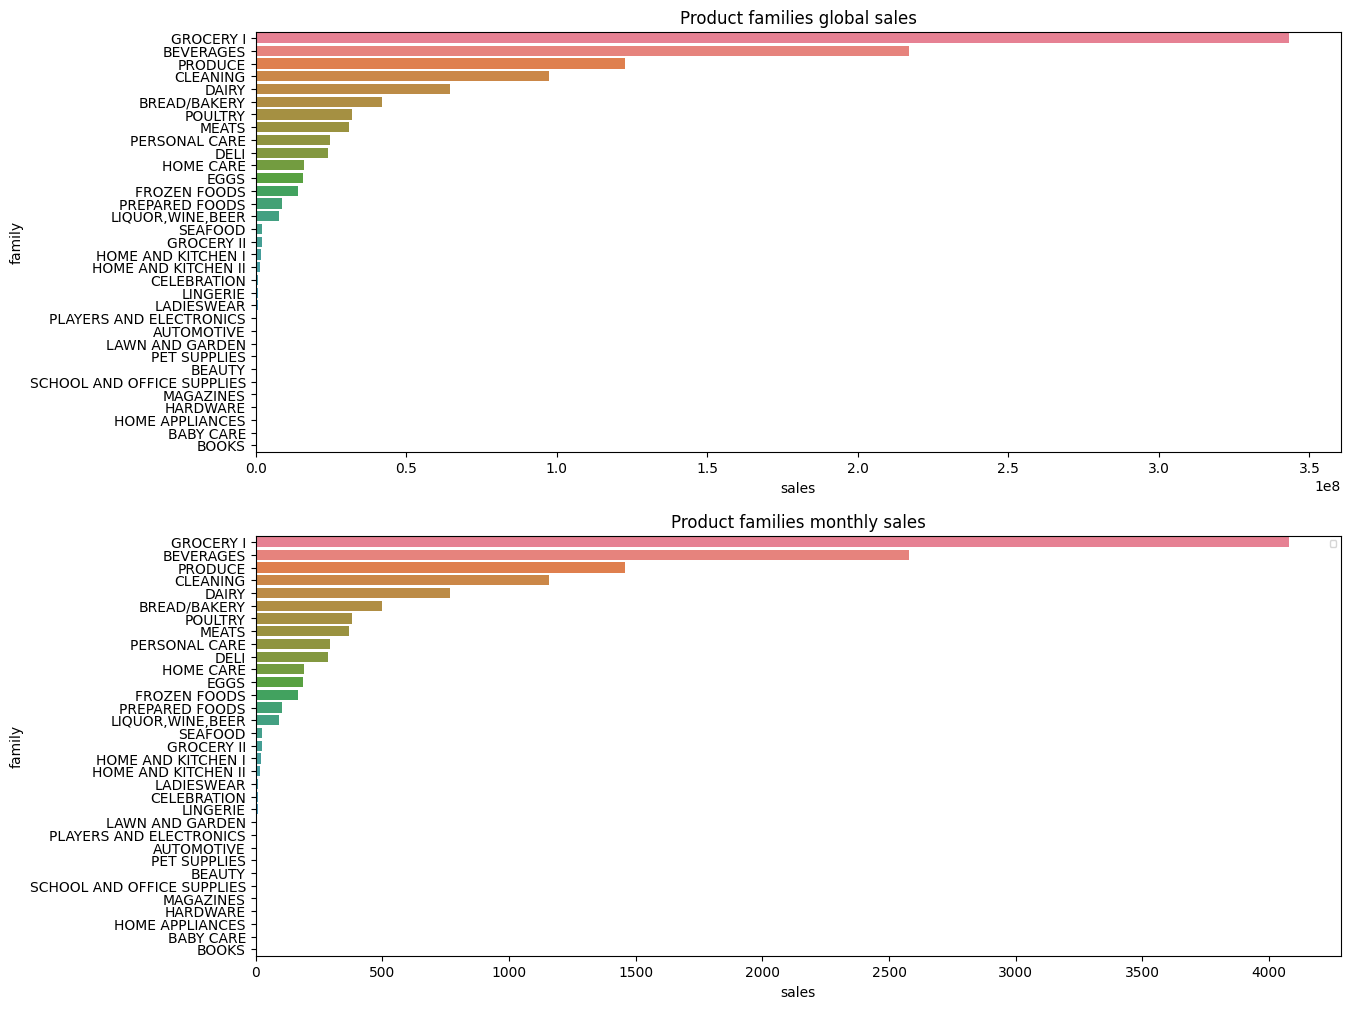

In [173]:
train_df_corrected

# let's plot preferred products
product_sales_sum = train_df_corrected.groupby("family").sales.sum().reset_index().sort_values("sales", ascending = False)
product_sales_sum

fig, axes = plt.subplots(ncols =1, nrows = 2, figsize = (14, 12))
# 1 barplot with sum()
sns.barplot(data = product_sales_sum, x = "sales", y = "family", hue = "family", ax = axes[0])


# barplot with mean()
product_sales_mean = train_df_corrected.groupby("family").sales.mean().reset_index().sort_values("sales", ascending = False)
product_sales_mean
sns.barplot(data = product_sales_mean, x = "sales", y = "family", hue = "family", ax = axes[1])

# plots options
axes[0].set_title("Product families global sales")
axes[1].set_title("Product families monthly sales")
axes[1].legend(fontsize=6,title_fontsize=10, labelspacing=0.7)
plt.show()

/tmp/ipython-input-3053005493.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  stores_df_by_month = train_df_corrected.set_index("date").groupby("store_nbr").resample("M").sales.mean().reset_index()


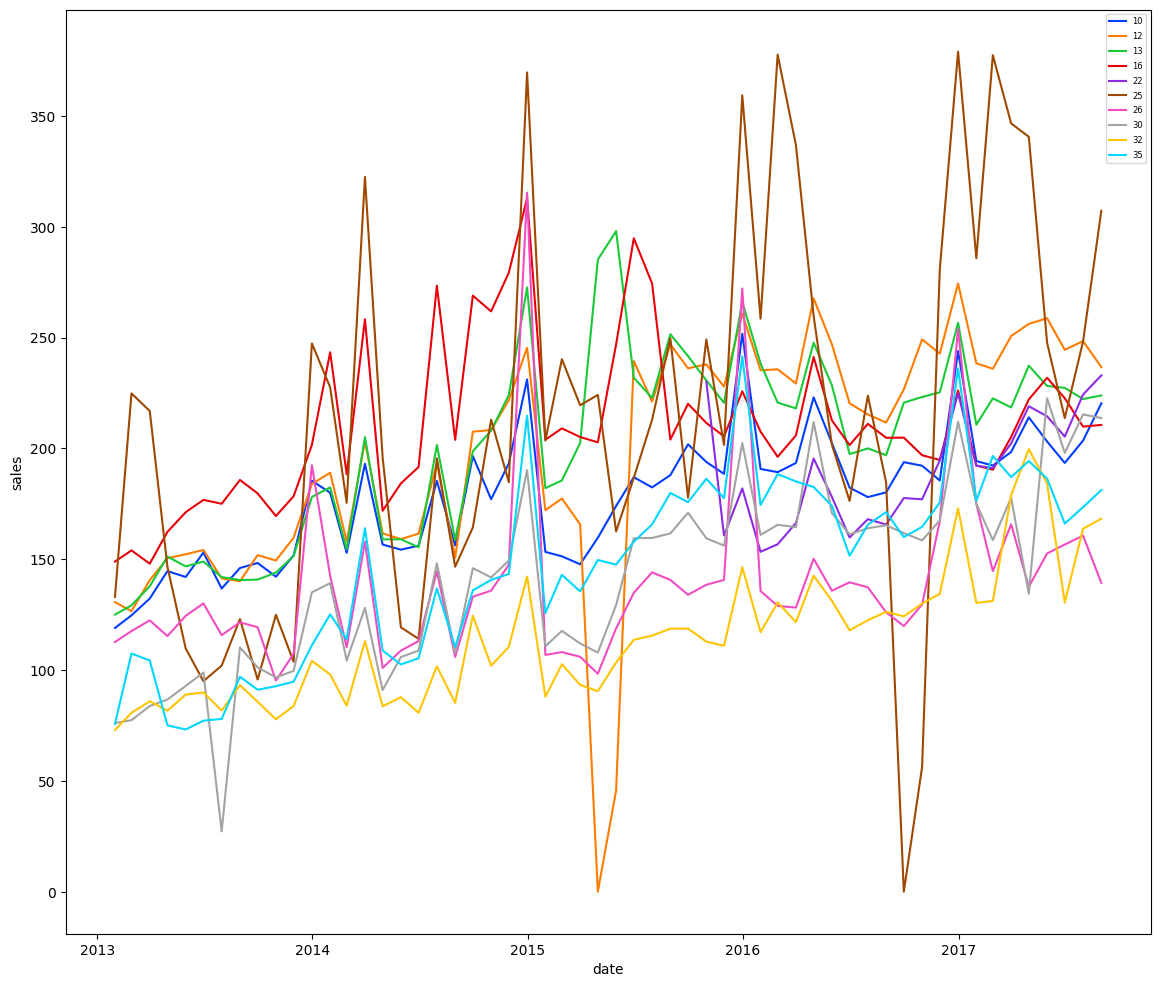

In [174]:
# best stores by month
stores_df_by_month = train_df_corrected.set_index("date").groupby("store_nbr").resample("M").sales.mean().reset_index()
stores_df_by_month

# plt.figure(figsize = (14,12))
# sns.lineplot(data = stores_df_by_month, x ="date" , y ="sales" , hue = "store_nbr", palette = "bright")
# plt.legend(fontsize=6,title_fontsize=10, labelspacing=0.7)
# plt.show()

# only keep the 10 bests
stores_df_best = train_df_corrected.groupby("store_nbr").sales.mean().sort_values().head(10).reset_index()


best_stores = stores_df_best["store_nbr"].to_list()
best_stores

stores_df_by_month_best = stores_df_by_month[stores_df_by_month["store_nbr"].isin(best_stores)]

plt.figure(figsize = (14,12))
sns.lineplot(data = stores_df_by_month_best, x ="date" , y ="sales" , hue = "store_nbr", palette = "bright")
plt.legend(fontsize=6,title_fontsize=10, labelspacing=0.7)
plt.show()


/tmp/ipython-input-3890024543.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  products_by_month = train_df_corrected.set_index("date").groupby("family").resample("M").sales.sum().reset_index()


[]

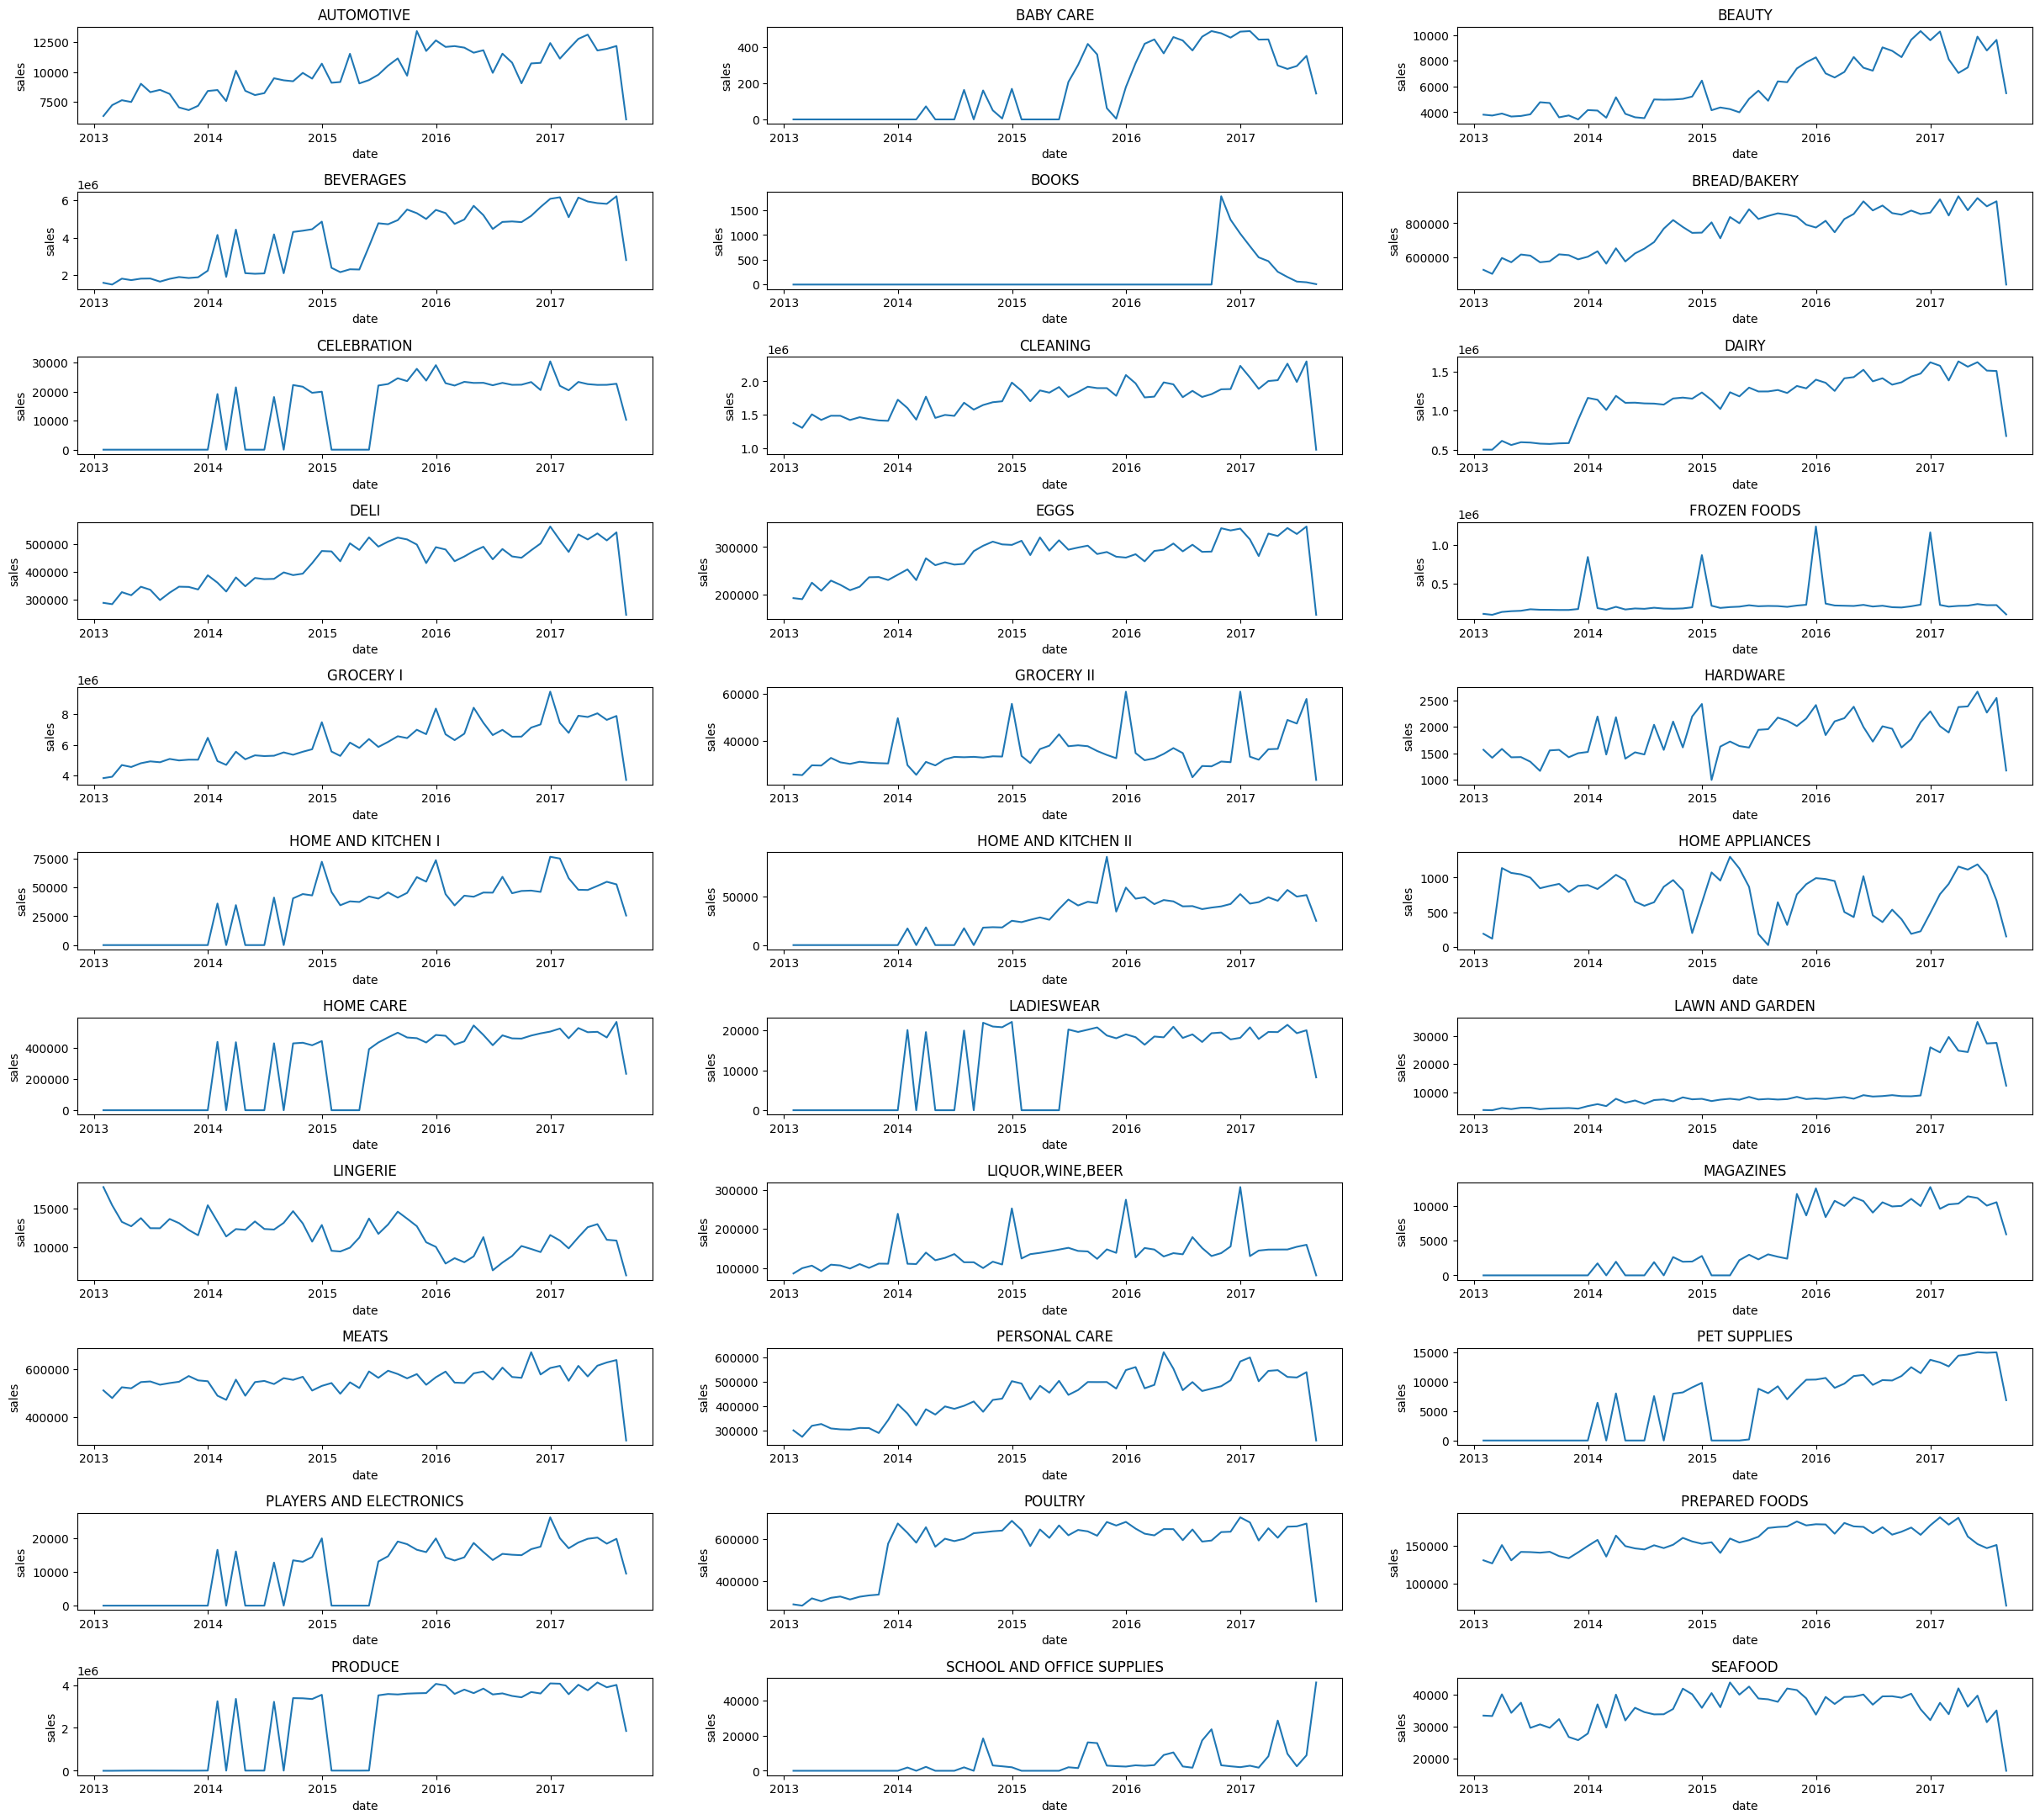

In [175]:
# FOr the time series by product family we don't see alot.
# there are several options to adapt it
# Let's make one plot by product

import math


products_by_month = train_df_corrected.set_index("date").groupby("family").resample("M").sales.sum().reset_index()

families = products_by_month["family"].unique()
families
nb_families = len(families)
nb_families # 33

ncols = 3
nrows = math.ceil(nb_families / ncols)
nrows

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (30, 9 * ncols))
axes = axes.flatten()
for i, family in enumerate(families):
  famil_i = products_by_month[products_by_month["family"] == family]
  sns.lineplot(data = famil_i, x = "date", y = "sales", ax = axes[i])
  axes[i].set_title(f'{family}')
# Augmente l’espace entre les lignes
plt.subplots_adjust(hspace=0.7)
plt.plot()


In [176]:
train_df_corrected.head(20)

id       date  store_nbr      family  sales  onpromotion
0    3564 2013-01-03          1  AUTOMOTIVE    3.0            0
1    5346 2013-01-04          1  AUTOMOTIVE    3.0            0
2    7128 2013-01-05          1  AUTOMOTIVE    5.0            0
3    8910 2013-01-06          1  AUTOMOTIVE    2.0            0
4   10692 2013-01-07          1  AUTOMOTIVE    0.0            0
5   12474 2013-01-08          1  AUTOMOTIVE    2.0            0
6   14256 2013-01-09          1  AUTOMOTIVE    2.0            0
7   16038 2013-01-10          1  AUTOMOTIVE    2.0            0
8   17820 2013-01-11          1  AUTOMOTIVE    3.0            0
9   19602 2013-01-12          1  AUTOMOTIVE    2.0            0
10  21384 2013-01-13          1  AUTOMOTIVE    2.0            0
11  23166 2013-01-14          1  AUTOMOTIVE    2.0            0
12  24948 2013-01-15          1  AUTOMOTIVE    1.0            0
13  26730 2013-01-16          1  AUTOMOTIVE    1.0            0
14  28512 2013-01-17          1  AUTOMOTIVE    1.0            0
15  30294 2013-01-18          1  AUTOMOTIVE    0.0            0
16  32076 2013-01-19          1  AUTOMOTIVE    5.0            0
17  33858 2013-01-20          1  AUTOMOTIVE    3.0            0
18  35640 2013-01-21          1  AUTOMOTIVE    1.0            0
19  37422 2013-01-22          1  AUTOMOTIVE    1.0            0

In [177]:
# plt.figure()
# sns.scatterplot(data = train_df_corrected, x ="date", y ="onpromotion")
# plt.show()

# let's compute the correlation between onpromotion and sales

correl = train_df_corrected["sales"].corr(train_df_corrected["onpromotion"], method = "spearman")


correl_2 = train_df_corrected["sales"].corr(train_df_corrected["onpromotion"], method = "pearson")

print(f'pearson correlation : {correl_2}, spearman correlation: {correl}')


pearson correlation : 0.4238556216117102, spearman correlation: 0.5305390560208131


In [178]:
# print("Spearman Correlation between Sales and Onpromotion: {:,.4f}".format(train_df.corr("spearman").sales.loc["onpromotion"]))

train_df

correl = train_df["sales"].corr(train_df["onpromotion"], method = "spearman")
correl


np.float64(0.5380218163559225)

<Figure size 1200x400 with 0 Axes>

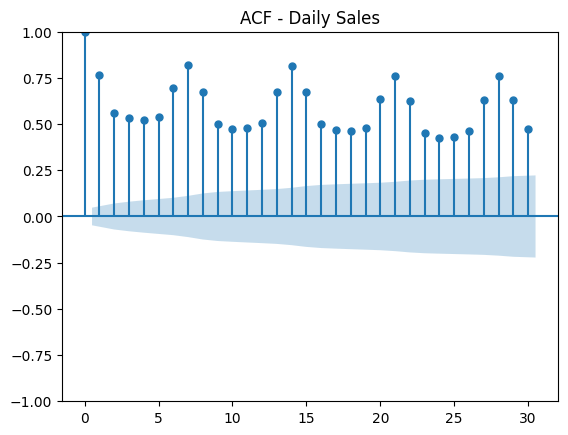

<Figure size 1200x400 with 0 Axes>

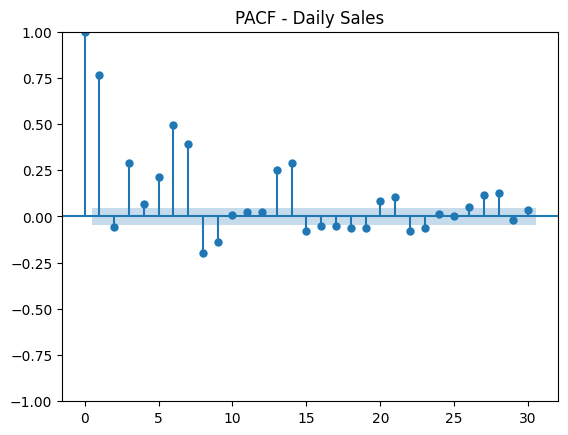

In [179]:
# PACF - ACF

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Série de base : ventes globales par jour
daily_sales = train_df_corrected.groupby("date")["sales"].sum()


lag = 30
plt.figure(figsize=(12, 4))
plot_acf(daily_sales, lags=lag)
plt.title("ACF - Daily Sales")
plt.show()
# strong weekly / biweekkly/ monthly correlation


plt.figure(figsize=(12, 4))
plot_pacf(daily_sales, lags=lag)
plt.title("PACF - Daily Sales")
plt.show()
# lag(1) and lag(7) mainly


In [180]:
# let's try with one specific family
fam = "GROCERY I"
fam_sales = train_df_corrected[train_df_corrected["family"] == fam].groupby("date")["sales"].sum()

# plot_acf(fam_sales, lags=30)
# plot_pacf(fam_sales, lags=30)

# Feature engineering

In [181]:
# Lelt's add lag components to our train data to remember past patterns
# lags
# day of week
# month
# year

train_df_corrected

train_df_enriched = train_df_corrected.copy()

# 1 day
train_df_enriched["sales_lag1"] = train_df_enriched.groupby(["store_nbr", "family"])["sales"].shift(1)
train_df_enriched

# 1 week
train_df_enriched["sales_lag7"] = train_df_enriched.groupby(["store_nbr", "family"])["sales"].shift(7)

# 1 month - 28days
train_df_enriched["sales_lag28"] = train_df_enriched.groupby(["store_nbr", "family"])["sales"].shift(28)

# rolling mean
train_df_enriched["sales_rollmean7"] = train_df_enriched.groupby(["store_nbr", "family"])["sales"].shift(1).rolling(7).mean()
#x.shift(1) : décale toutes les ventes d’un jour vers le bas (on ne veut pas inclure la vente du jour dans la moyenne !)
# rolling(7) : crée une fenêtre de 7 jours

# rolling std
train_df_enriched["sales_rollstd7"] = train_df_enriched.groupby(["store_nbr", "family"])["sales"].shift(1).rolling(7).std()
train_df_enriched

# day of week
train_df_enriched["day_of_week"] = train_df_enriched["date"].dt.dayofweek.astype("category")

# month
train_df_enriched["month"] = train_df_enriched["date"].dt.month.astype("category")

# holiday
# before adding holiday data, let's create the correspondinng var and putting at 0 by default

train_df_enriched["is_holiday"] = False
train_df_enriched.head()


id       date  store_nbr      family  sales  onpromotion  sales_lag1  \
0   3564 2013-01-03          1  AUTOMOTIVE    3.0            0         NaN   
1   5346 2013-01-04          1  AUTOMOTIVE    3.0            0         3.0   
2   7128 2013-01-05          1  AUTOMOTIVE    5.0            0         3.0   
3   8910 2013-01-06          1  AUTOMOTIVE    2.0            0         5.0   
4  10692 2013-01-07          1  AUTOMOTIVE    0.0            0         2.0   

   sales_lag7  sales_lag28  sales_rollmean7  sales_rollstd7 day_of_week month  \
0         NaN          NaN              NaN             NaN           3     1   
1         NaN          NaN              NaN             NaN           4     1   
2         NaN          NaN              NaN             NaN           5     1   
3         NaN          NaN              NaN             NaN           6     1   
4         NaN          NaN              NaN             NaN           0     1   

   is_holiday  
0       False  
1       False  
2       False  
3       False  
4       False

In [182]:
stores_df[stores_df["state"] =="Cotopaxi"]

store_nbr       city     state type  cluster
11         12  Latacunga  Cotopaxi    C       15
12         13  Latacunga  Cotopaxi    C       15

In [183]:
localities = hl_events_df["locale_name"].unique() # can be cities or regions

cities = stores_df["city"].unique()
states = stores_df["state"].unique()

# common = set(cities) & set(localities)

# differ = set(localities).symmetric_difference(set(cities))


missing = [i for i in cities if i not in localities]
missing

# so here we have ['Daule', 'Babahoyo', 'Playas'] which are cities with at least a store associated (stores_df),
# so present in train as well, but for which no local holiday is associated (only national)


check1 = [city for city in cities if city not in localities]
check1

check2 = [city for city in states if city in localities ] # Regions => link between stores_df["state"] and regional holidays (see below)
check2

check1

['Daule', 'Babahoyo', 'Playas']

In [184]:
# let's divide the datset into 3 sub ones.
# 1 national, merged by date
# 1 regional that we need to link to the corresponding cities (State == Cotopaxi => City == Latacunga)
# 1 local by merge by [date, city]


## National
# for national holiday there is also "transferred" (jours feries reportés) that we need to handle
national_holiday = hl_events_df[hl_events_df["locale"] == "National"]
national_holiday[(national_holiday["type"] == "Transfer") | (national_holiday["transferred"] == True)]
# need to only keep when ((type == Holiday) & (transferred == False)) | (type == Transfer)
national_holiday = national_holiday[( (national_holiday["type"]=="Holiday") & (national_holiday["transferred"]==False) ) |
                                    (national_holiday["type"]=="Transfer") ]

national_holiday.head() # this one can be directly merge to train on date


date      type    locale locale_name  \
14 2012-08-10   Holiday  National     Ecuador   
20 2012-10-12  Transfer  National     Ecuador   
21 2012-11-02   Holiday  National     Ecuador   
22 2012-11-03   Holiday  National     Ecuador   
37 2012-12-25   Holiday  National     Ecuador   

                            description  transferred  
14        Primer Grito de Independencia        False  
20  Traslado Independencia de Guayaquil        False  
21                      Dia de Difuntos        False  
22              Independencia de Cuenca        False  
37                              Navidad        False

In [185]:

## Local
local_holiday = hl_events_df[hl_events_df["locale"] == "Local"]
# same logic as for national
local_holiday[(local_holiday["type"] == "Transfer") | (local_holiday["transferred"] == True)]
local_holiday = local_holiday[( (local_holiday["type"]=="Holiday") & (local_holiday["transferred"]==False) ) |
                                    (local_holiday["type"]=="Transfer") ]
local_holiday # this one is to be merge to train on ["locale_name" == "city"] to store_df, and then on store_nbr and date to train



date      type locale locale_name                  description  \
0   2012-03-02   Holiday  Local       Manta           Fundacion de Manta   
2   2012-04-12   Holiday  Local      Cuenca          Fundacion de Cuenca   
3   2012-04-14   Holiday  Local    Libertad    Cantonizacion de Libertad   
4   2012-04-21   Holiday  Local    Riobamba    Cantonizacion de Riobamba   
5   2012-05-12   Holiday  Local        Puyo       Cantonizacion del Puyo   
..         ...       ...    ...         ...                          ...   
337 2017-11-11   Holiday  Local   Latacunga   Independencia de Latacunga   
338 2017-11-12   Holiday  Local      Ambato      Independencia de Ambato   
341 2017-12-08   Holiday  Local        Loja            Fundacion de Loja   
342 2017-12-08  Transfer  Local       Quito  Traslado Fundacion de Quito   
344 2017-12-22   Holiday  Local     Salinas     Cantonizacion de Salinas   

     transferred  
0          False  
2          False  
3          False  
4          False  
5          False  
..           ...  
337        False  
338        False  
341        False  
342        False  
344        False  

[137 rows x 6 columns]

In [186]:
## Regional
regional_holiday = hl_events_df[hl_events_df["locale"] == "Regional"]
regional_holiday.head() # no transferred holiday
# to be linked to stores df on ["locale_name" == "state"]



date     type    locale                     locale_name  \
1  2012-04-01  Holiday  Regional                        Cotopaxi   
7  2012-06-25  Holiday  Regional                        Imbabura   
23 2012-11-06  Holiday  Regional  Santo Domingo de los Tsachilas   
24 2012-11-07  Holiday  Regional                     Santa Elena   
47 2013-04-01  Holiday  Regional                        Cotopaxi   

                           description  transferred  
1        Provincializacion de Cotopaxi        False  
7        Provincializacion de Imbabura        False  
23  Provincializacion de Santo Domingo        False  
24       Provincializacion Santa Elena        False  
47       Provincializacion de Cotopaxi        False

In [187]:
# now lets merge these datasets

# merge regional with stores
regional_holiday = pd.merge(left= regional_holiday, right = stores_df[["store_nbr","state"]], how = "left",
                            left_on = "locale_name", right_on = "state")
regional_holiday = regional_holiday[["date", "store_nbr"]]
regional_holiday["reg_holiday"] = True
regional_holiday.head()



date  store_nbr  reg_holiday
0 2012-04-01         12         True
1 2012-04-01         13         True
2 2012-06-25         15         True
3 2012-11-06          5         True
4 2012-11-06         16         True

In [188]:
# merge local with stores
local_holiday = pd.merge(left= local_holiday, right = stores_df[["store_nbr","city"]], how = "left",
                            left_on = "locale_name", right_on = "city")
local_holiday = local_holiday[["date", "store_nbr"]]
local_holiday["loc_holiday"] = True
local_holiday



date  store_nbr  loc_holiday
0   2012-03-02         52         True
1   2012-03-02         53         True
2   2012-04-12         37         True
3   2012-04-12         39         True
4   2012-04-12         42         True
..         ...        ...          ...
329 2017-12-08         46         True
330 2017-12-08         47         True
331 2017-12-08         48         True
332 2017-12-08         49         True
333 2017-12-22         25         True

[334 rows x 3 columns]

In [189]:
# clean national before merfging with train
national_holiday = national_holiday[["date"]]
national_holiday["nat_holiday"] = True
national_holiday.head()


date  nat_holiday
14 2012-08-10         True
20 2012-10-12         True
21 2012-11-02         True
22 2012-11-03         True
37 2012-12-25         True

In [190]:
train_df_enriched

# now let's merge

# local
train_df_enriched_merged = pd.merge(left = train_df_enriched, right = local_holiday , how = "left", on = ["date", "store_nbr"])
train_df_enriched_merged["is_holiday"] = train_df_enriched_merged["is_holiday"].fillna(False) | train_df_enriched_merged["loc_holiday"].fillna(False)
train_df_enriched_merged.loc[train_df_enriched_merged["is_holiday"] == True] # looks ok
train_df_enriched_merged = train_df_enriched_merged.drop(columns = ["loc_holiday"])






/tmp/ipython-input-2969137487.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df_enriched_merged["is_holiday"] = train_df_enriched_merged["is_holiday"].fillna(False) | train_df_enriched_merged["loc_holiday"].fillna(False)


In [191]:
# regional
train_df_enriched_merged = pd.merge(left = train_df_enriched_merged, right = regional_holiday , how = "left", on = ["date", "store_nbr"])
train_df_enriched_merged["is_holiday"] = train_df_enriched_merged["is_holiday"].fillna(False) | train_df_enriched_merged["reg_holiday"].fillna(False)
train_df_enriched_merged.loc[train_df_enriched_merged["is_holiday"] == True] # looks ok
train_df_enriched_merged = train_df_enriched_merged.drop(columns = ["reg_holiday"])




/tmp/ipython-input-601110211.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df_enriched_merged["is_holiday"] = train_df_enriched_merged["is_holiday"].fillna(False) | train_df_enriched_merged["reg_holiday"].fillna(False)


In [192]:
# national => date only
train_df_enriched_merged = pd.merge(left = train_df_enriched_merged, right = national_holiday , how = "left", on = ["date"])
train_df_enriched_merged["is_holiday"] = train_df_enriched_merged["is_holiday"].fillna(False) | train_df_enriched_merged["nat_holiday"].fillna(False)
train_df_enriched_merged.loc[train_df_enriched_merged["is_holiday"] == True] # looks ok
train_df_enriched_merged = train_df_enriched_merged.drop(columns = ["nat_holiday"])

train_df_enriched_merged


# tres clean selon chatgpt
# Excellente gestion de la logique (Holiday & !transferred) | Transfer
# C’est exactement ce que fait Kaggle dans les notebooks bien notés.





/tmp/ipython-input-982230773.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df_enriched_merged["is_holiday"] = train_df_enriched_merged["is_holiday"].fillna(False) | train_df_enriched_merged["nat_holiday"].fillna(False)


id       date  store_nbr      family  sales  onpromotion  \
0           3564 2013-01-03          1  AUTOMOTIVE    3.0            0   
1           5346 2013-01-04          1  AUTOMOTIVE    3.0            0   
2           7128 2013-01-05          1  AUTOMOTIVE    5.0            0   
3           8910 2013-01-06          1  AUTOMOTIVE    2.0            0   
4          10692 2013-01-07          1  AUTOMOTIVE    0.0            0   
...          ...        ...        ...         ...    ...          ...   
2695473  2993627 2017-08-11         54     SEAFOOD    0.0            0   
2695474  2995409 2017-08-12         54     SEAFOOD    1.0            1   
2695475  2997191 2017-08-13         54     SEAFOOD    2.0            0   
2695476  2998973 2017-08-14         54     SEAFOOD    0.0            0   
2695477  3000755 2017-08-15         54     SEAFOOD    3.0            0   

         sales_lag1  sales_lag7  sales_lag28  sales_rollmean7  sales_rollstd7  \
0               NaN         NaN          NaN              NaN             NaN   
1               3.0         NaN          NaN              NaN             NaN   
2               3.0         NaN          NaN              NaN             NaN   
3               5.0         NaN          NaN              NaN             NaN   
4               2.0         NaN          NaN              NaN             NaN   
...             ...         ...          ...              ...             ...   
2695473         2.0         0.0          0.0         3.000000        4.281744   
2695474         0.0         3.0          2.0         3.000000        4.281744   
2695475         1.0         0.0          5.0         2.714286        4.347960   
2695476         2.0         0.0          3.0         3.000000        4.203173   
2695477         0.0        12.0          6.0         3.000000        4.203173   

        day_of_week month  is_holiday  
0                 3     1       False  
1                 4     1       False  
2                 5     1       False  
3                 6     1       False  
4                 0     1       False  
...             ...   ...         ...  
2695473           4     8        True  
2695474           5     8       False  
2695475           6     8       False  
2695476           0     8       False  
2695477           1     8       False  

[2695478 rows x 14 columns]